# EPFL-MICRO452 - Mobile Robotics Project
Project for the Mobile Robotic course, fall semester 2024

## Group Members
**Rocca Federico** (390233) - First year MSc in Robotics at EPFL, previous degree BSc in Computer Engineering at Politecnico di Milano  
**Rashidi Mohammad Massi** (394309) - First year MSc in CyberSecurity at EPFL previous degree BSc in Computer Science at University of Geneva       
**Rawas Mouhamad Bilal** (345489) - First year MSc in Robotics at EPFL, previous degree BSc in Microengineering at EPFL    
**Schär Mikaël Joël Michel** (325388) - First year MSc in Robotics at EPFL, previous degree BSc in Microengineering at EPFL

## Introduction
The aim of the project is to build a system able of controlling a <a href="https://www.thymio.org/" target="_blank">Thymio</a> robot. This system shoud integrate all the main modules that are tipically found in a simple mobile robot:
- **Vision**
- **Global Navigation**
- **Local Navigation**
- **Filtering**

The robot should will be placed in an **environment** (explained later) where there are some **permanent obstacles**. Given a **camera view** of the environment, a **global plan** should be generated, starting from the Thymio's position, leading to the goal and avoiding the permanent obstacles. Some **random obstacles** may be introduced in the environment during the movement of the robot from start to goal, and it should be able to avoid them. The robot should be localized both using the camera image, that can be obstructed on purpose from time to time, and the odometry, by fusing them with the **filtering**.

### Demo
Here's a demo of the system working:  
<p align="center">
  <video width="640" height="480" controls>
    <source src="video.mov" type="video/mp4">
  </video>
</p>

### Environment
The environment that the robot has to navigate has been designed by us, and it consists of a **white floor**, the traversable space, where we placed some **black cutouts**, that represent permanent obstacles, while the goal position is indicated by a **red mark** placed on the floor.  
<p align="center">
    <img src="images/env_image.png" width="400">
</P>
In order to detect the white Thymio robot in the white background we decided to place an <a href="https://april.eecs.umich.edu/software/apriltag" target="_blank">AprilTag</a> on its top. It is used both for detecting the robot's position and orientation.
We also attached 4 AprilTags on the 4 corners of the environment in order to straighten the image that the camera records and generate precise measurements based on that image.  
<!-- Tag du robot -->
<p align="center">
    <span style="display: block; font-weight: bold; margin-bottom: 10px;">Tag corresponding to the robot</span>
    <img src="images/tag.png" width="200" style="margin: 10px;">
</p>

<!-- Tags des 4 coins -->
<p align="center">
    <span style="display: block; font-weight: bold; margin-bottom: 10px;">Tags corresponding to the 4 corners of the image</span>
    <img src="images/tagStandard41h12-100.svg" width="200" style="margin: 10px;">
    <img src="images/tagStandard41h12-113.svg" width="200" style="margin: 10px;">
    <img src="images/tagStandard41h12-141.svg" width="200" style="margin: 10px;">
    <img src="images/tagStandard41h12-283.svg" width="200" style="margin: 10px;">
</p>

#### Features Implemented
- The **vision** module generates the map of the environment, starting from a camera image.
- The **vision** module also tracks the pose of the robot.
- The information from the **vision** is also used to detect and solve any kidnapping situation, by relocalizing the robot in the map
- The **global navigation** module, given the map of the environment, with a starting position and a goal, deigns the optimal plan using the Dijkstra algorithm.
- The Thymio control module generates the movement commands that allow the robot to move along the path from start to finish
- The **local navigation** module is used for avoiding the unexpected obstacles that might be detected along the path
- The **filtering** module implements a Kalman filter in order to better localize the robot. It predicts the robots position given the movements made and updates the prediction using data from the vision.

# Explanation of Implemented Modules
The next sections will explain how each module is implemented and how it works.

## **Vision**

The Vision system detects the 4 corners of the map using AprilTags to align and straighten the image, identifies the robot’s position and orientation with a specific tag, locates the goal by detecting red zones, and generates a matrix that represents the map by highlighting obstacles, which correspond to the black areas on the map, and the accessible areas available for the Thymio robot to navigate. The system calculates and returns the map scale in pixels per centimeter for precise navigation by the Thymio.

<h2 align="center">Demo of Vision System</h2>

<!-- Step 1: Original Image -->
<p align="center">
    <strong>1. Original Image Captured</strong><br>
    <img src="images/original_image.jpeg" width="500" style="margin: 10px;">
</p>

<!-- Step 2: Cropped Image -->
<p align="center">
    <strong>2. Cropped and Aligned Image</strong><br>
    <img src="images/cropped_image.jpeg" width="500" style="margin: 10px;">
</p>

<!-- Step 3: Image with Start and Goal Highlighted -->
<p align="center">
    <strong>3. Image with the center of the Start and the Goal Highlighted</strong><br>
    <img src="images/start_goal_highlighted.jpg" width="500" style="margin: 10px;">
</p>

<!-- Step 4: Image with Red Regions and Tags Whitened -->
<p align="center">
    <strong>4. Image with Red Regions and Robot's Tags Whitened</strong><br>
    <img src="images/whitened_regions.jpg" width="500" style="margin: 10px;">
</p>

<!-- Step 5: Final Map with Obstacles Highlighted -->
<p align="center">
    <strong>5. Final Binary Map Showing Obstacles</strong><br>
    <img src="images/binary_obstacle_map.jpg" width="500" style="margin: 7px;">
</p>

## **Global Planning**
The goal of this project is to achieve a position with the robot. To make this happen, we will use the global navigation. It's the same principle than follow a GPS, we build a path that our thymio will follow. This path start from the position of the thymio, and ends at the position of our goal placed on our environment.

## **Dijkstra's Algorithm**

This algorithm work with the use of a grid as a map. In this grid, we will search the most efficient path to achieve our goal. Here an exemple of a grid take from the serie of exercice 5 :

<p align="center">
    <strong>Grid with the start "S" and the goal "G"</strong><br>
    <img src="images/Dijkstra 1.png" width="250" style="margin: 10px;">
</p>

-The first step is to number all the cell of the map from start to goal. To do this at each step from the start, we take all the neighbors and assign cells one unit larger than the previous one. An Exemple is provide for better understanding :

<p align="center">
    <strong>Grid with the first iterations of the algorithm</strong><br>
    <img src="images/Dijkstra 2.png" width="250" style="margin: 10px;">
</p>

-The second step is to find the most optimized path. To find it, we take our grid and start from the goal. We take all the neighbors and we assign the cell with the smallest number as part of the path. Here an exemple of the shortest path between start and goal.

<p align="center">
    <strong>Grid with the most optimized path in gray</strong><br>
    <img src="images/Dijkstra 3.png" width="250" style="margin: 10px;">
</p>

in our code, we make this algorithm with the 8-connected grid, so we also take into account the diagonals of the current cell's neighbors. We can see the difference between the example here and how we doing in our code.

<p align="center">
    <strong>4 and 8-connected grid</strong><br>
    <img src="images/4-connected grid.png" width="250" style="margin: 10px;">
    <img src="images/8-connected grid.png" width="250" style="margin: 10px;">
</p>

## **Local Planning**
Once the global navigation module has designed a path from the start position to the goal, the local planning module has to generate the movement commands for the robot in such a way that it will follow that path, all while avoiding unexpected obstacles that might be detected while moving from the start position to the goal.

### **Motion Control**
The motion control, that is the process of generating motion commands to get the robot to follow the path generated by the global plannign module, is implemented in the <code>ThymioControl</code> class in <code>thymioControl.py</code>

#### **Path Reduction**
As a first step, it reduces the path to the minumum sequence of waypoints. This means that all the points in the path that lay on the same straight line, excluding the first and last, are removed. Here is shown an example of this behavior.  
<div style="display: flex; justify-content: space-between;">
  <img src="images/ogPath.png" alt="Original path" style="width: 45%;"/>
  <img src="images/reducedPath.png" alt="Reduced path" style="width: 45%;"/>
</div>

#### **Kidnapping Detection**
This module is also used for recognizing kidnapping situations. This means that when the pose of the Thymio is updated, based on the measurement from the camera, it is compared with the previous pose, and if the position or the angle differ by more than the relative thresholds <code>self.__kidnappingThresholdPosition</code> and <code>self.__kidnappingThresholdAngle</code>, a kidnapping situation is signaled and the kidnapping routine, explained later, is run.

#### **Movement Generation**
Given the current position and angle of the Thymio and the position of the next waypoint in the path that needs to be reached, the required velocity commands are calculated in this module. Two different approaches are present in the file: <code>move_pd(position, angle)</code> or <code>move(position, angle)</code>
- <code>move_pd</code>: computes the distance from the robot to the waypoint, and if it is less than the threshold <code>self.__reachedThreshold</code> it considers the waypoint reached and moves on to the next. The linear speed is considered always constant, while the angular speed is calculated using a PD controller, based on the angle difference between the Thymio orientation and the relative angle of the waypoint in respect to the robot and on the previous angle difference. The linear and angular speed are then used to compute the left and right motor speeds using differential drive kinematics.  
  PD controller: $w = k_p \cdot \text{angleDistance} + k_d \cdot \frac{\text{angleDistance} - \text{previousAngleDistance}}{dt}$, with $k_p$ and $k_d$ respectively the proportional and derivative gain
- <code>move</code>: computes the distance from the robot to the waypoint, and if it is less than the threshold <code>self.__reachedThreshold</code> it considers the waypoint reached and moves on to the next. This time, when an angle difference is detected between the Thymio's orientation and the direction throwards the waypoint, the robot is stopped (linear speed = 0), and it is turned on the spot. The angolar velocity used for turned is once again calculated using a PD controller. If instead the angle difference is less then the threshold <code>self.__angleThreshold</code>, the angolar velocity is set to 0 and the linear velocity is set to a predetermined constant value, making the Thymio go straight throwards the waypoint.
While the first method never stops the robot, so it is potentially faster and smoother, tuning the parameters $k_p$ and $k_d$ wrongly may lead to overshoots or oscillations. On the other hand, the stop-rotate-go controller is more precise but obviously slower, since the robot has to stop before turning on the spot.

### Local Avoidance
An important part in robot's navigation is the avoidance of unexpected obstacles that might be detected while moving from the start position to the goal, following the global plan. The process of local avoidance consists of detecting the obstacles using the robots sensors and designing a more or less efficient plan to get around it, avoiding collisions, and get back on the predetermined global plan.
The python file <code>localPlanning.py</code> contains the <code>LocalPlanning</code> class that implements the local avoidance modules.

#### Obstacle Detection
The Thymio robot features 5 horizontal proximity sensors it its front part (see Thyimio cheat sheet snippet) that can be used to detect obstacles using infrared technology. The range of values that the sensors return is [0, 4300] and the updates come at a frequency of 10Hz.
When the <code>self.is_obstacle_avoidance(prox_horizontal)</code> method is called, a boolean value is returned, <code>True</code> if any of the sensors is reading higher than the threshold, <code>False</code> otherwise.

#### Obstacle Avoidance
If an obstacle is detected, the obstacle avoidance routine <code>self.obstacle_avoidance</code> uses a 



## **Kalman Filter**

The Kalman Filter is a mathematical tool used in this project to estimate the robot's position and orientation (state) while navigating toward a goal. The robot uses data from two sources: **odometry** (wheel speeds) for prediction and a **camera** for occasional updates. Since both these sources are noisy and prone to errors, the Kalman Filter combines their information to produce an accurate and smooth estimate of the robot’s state.

#### **Nonlinear Motion Model**

A differential-drive robot's motion is inherently nonlinear because its position $(x, y)$ and orientation $\theta$ depend on trigonometric relationships. For example, its state evolves as (motion model):

$$
x_{t+1} = x_t + v \cos(\theta) \Delta t, \quad y_{t+1} = y_t + v \sin(\theta) \Delta t, \quad \theta_{t+1} = \theta_t + \omega \Delta t
$$

Here:
- $v$: Linear velocity (derived from wheel speeds).
- $\omega$: Angular velocity (based on differential wheel motion).
- $\Delta t$: Time step.

The EKF linearizes these equations using the Jacobian of the motion model. In the **Kalman class**, the motion model is embedded in the matrix $\mathbf{G}$

#### **Fusing Odometry and Camera Data**

Odometry (wheel encoder data) is prone to errors such as:

- **Drift** over time, accumulating inaccuracies as the robot moves.
- **Wheel slippage** and uneven terrain causing deviations from the true trajectory.

The camera, while more accurate, provides intermittent data due to potential obstructions or missed detections. The EKF combines these two sources of data to provide a reliable state estimate:

1. **Prediction Step**: This step uses the odometry data to predict the robot's next state. It always runs, regardless of whether camera data is available, ensuring continuity in state estimation. The prediction compensates for missing measurements and accounts for process noise.

2. **Update Step**: This step completes the prediction using camera measurements when available. It refines the estimated state by fusing the relatively accurate camera data with the prediction. The update step only runs if the camera is not obstructed.

#### **How the Kalman Filter Works**

**A. Prediction Step**

Using the robot's last known state, wheel speeds, and time elapsed (Δt), the Kalman Filter predicts the robot's next state:

$$
\mathbf{E}_{\text{pred}} = \mathbf{A} \cdot \mathbf{E} + \mathbf{G} \cdot \mathbf{U}
$$

- **A**: State transition matrix (accounts for constant movement without changes).
- **B**: Control matrix (maps wheel speeds to motion).
- **U**: Control vector (wheel speeds).

It also predicts the **uncertainty** in the state, denoted by the covariance matrix **P**:

$$
\mathbf{P}_{\text{pred}} = \mathbf{A} \cdot \mathbf{P} \cdot \mathbf{A}^T + \mathbf{R}
$$

- **Q**: Process noise covariance (uncertainty from wheel encoders).

**B. Update Step**

When the camera provides a measurement **Z**, the Kalman Filter updates the state and uncertainty:

1. Compute the Kalman gain **K**, which determines how much weight to give to the measurement:

$$
\mathbf{K} = \mathbf{P}_{\text{pred}} \cdot \mathbf{H}^T \cdot \left(\mathbf{H} \cdot \mathbf{P}_{\text{pred}} \cdot \mathbf{H}^T + \mathbf{Q}\right)^{-1}
$$

- **H**: Measurement matrix (maps state to camera readings).
- **R**: Measurement noise covariance (uncertainty in camera data).

2. Update the state using the measurement:

$$
\mathbf{E}_{\text{update}} = \mathbf{E}_{\text{pred}} + \mathbf{K} \cdot \left(\mathbf{Z} - \mathbf{H} \cdot \mathbf{E}_{\text{pred}}\right)
$$

3. Update the uncertainty:

$$
\mathbf{P}_{\text{update}} = (\mathbf{I} - \mathbf{K} \cdot \mathbf{H}) \cdot \mathbf{P}_{\text{pred}}
$$

### **Behavior in the Control Loop**

1. **Prediction Always Happens**:
    * The prediction step runs at every iteration using odometry.
    * This ensures the robot always has an estimated position, even if the camera data is unavailable.

2. **Update Happens When the Camera Sees the Robot**:
    * If the camera detects the robot, the Kalman Filter corrects its prediction using the more accurate camera measurement.

3. **Handling Obstructions**:
    * If the camera is obstructed, the filter relies solely on the prediction step until the camera resumes detection.


# Tuning of Parameters
The following section explains how the various parameters used throughout the project where selected and tuned.

- **Obstacle Detection Threshold**: the Thymio robot features 5 horizontal **proximity sensors** it its front part (see Thyimio cheat sheet snippet) that can be used to detect obstacles using infrared technology. The range of values that the sensors return is [0, 4300] and the updates come at a frequency of 10Hz.
    <p align="center">
        <img src="images/thymio_cheat_sheet1.png" width="800">
    </p>
    It is possible to map the readings from the proximity sensors to the real world distance measurements in order to tune the threshold for activating the local avoidance routine. In order to do so, many measurements were taken with an obstacle at a known distance, for multiple distances, and then a linear interpolation allowed to find the function of the form

    $f(\text{sensor\_reading}) = \text{distance} = \alpha \cdot \text{sensor\_reading} + \beta$

    that maps sensor readings to obstacle distance.  
    The mapping has been calculated to be: 
    
    $distance = n \cdot sensor\_reading + m$

    The following table shows the measurements that allowed to reconstruct the mapping:

    | Distance | Sensor Reading (average value) |
    | --- | ---: |
    | 5 | 12343 |
    | 10 | 123414 |
    | 20 | 324123 |

- **Parameters**

1. **Conversion ratio from Thymio speed (PWM) to mm/s**:  
   This was calculated by measuring the distance covered over time using ground sensor peaks. The Thymio's speed in mm/s was divided by the corresponding PWM value to determine the conversion ratio.

2. **Variance of speed in mm²/s²**:  
   The speed variance was computed as the variance of the recorded speed data (in mm/s) after converting using the conversion ratio and excluding initial transients. The variance was split equally between the **speed state** variance and the **speed measurement** variance, each being half of the total variance.   

3. **Motor speed adjustment scalar**:  
   A scalar adjustment was applied to one motor’s PWM to correct for a speed imbalance between the left and right motors. This value was determined empirically through testing to ensure straight-line movement.


# Code
The next section presents the runnable cells that allow the system to work.

## Imports
First step, all the classes that have been explained above need to be imported.
In order to be sure that all the python packages are correctly installed and ready to use, it is suggested to run <code>pip install -r requirements.txt</code> to get all of them. It should be noted that the <code>pupil-apriltags</code> package may give some problems with python versions higer than 3.10

In [1]:
# import all the classes in the package
from vision import Vision
from globalPlanning import GlobalPlanning
from thymioControl import ThymioControl
from localPlanning import LocalPlanning
from kalman import Kalman
from plotter import Plotter

We also need to install the <code>tdmclient</code> package, used for connecting and comunicating with the Thymio. The control from the notebook is made possible by the import of <code>tdmclient.notebook</code>.

In [2]:
# pip install tdmclient
!pip3 install tdmclient --upgrade

# import the TDMClient module
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
import time
import numpy as np

## TdmClient Functions
The following functions are used for modifying the variables in the Thymio, by comunicating through the tdmclient.
Specifically

In [4]:
@tdmclient.notebook.sync_var
def motor_go(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

@tdmclient.notebook.sync_var
def leds_off():
    global leds_top, leds_bottom_left, leds_bottom_right, leds_circle
    leds_top = [0, 0, 0]
    leds_bottom_left = [0, 0, 0]
    leds_bottom_right = [0, 0, 0]
    leds_circle = [0, 0, 0, 0, 0, 0, 0, 0]

def leds_go_crazy():
    for i in range(8):
        leds_1()
        time.sleep(0.1)
        leds_2()
        time.sleep(0.1)
        leds_3()
        time.sleep(0.1)

@tdmclient.notebook.sync_var
def leds_1():
    global leds_top, leds_bottom_left, leds_bottom_right, leds_circle
    leds_top = [32, 0, 0]
    leds_bottom_left = [0, 32, 0]
    leds_bottom_right = [0, 0, 32]
    leds_circle = [32, 32, 32, 32, 0, 0, 0, 0]

@tdmclient.notebook.sync_var
def leds_2():
    global leds_top, leds_bottom_left, leds_bottom_right, leds_circle
    leds_top = [0, 32, 0]
    leds_bottom_left = [0, 0, 32]
    leds_bottom_right = [32, 0, 0]
    leds_circle = [0, 0, 0, 0, 32, 32, 32, 32]

@tdmclient.notebook.sync_var
def leds_3():
    global leds_top, leds_bottom_left, leds_bottom_right, leds_circle
    leds_top = [0, 0, 32]
    leds_bottom_left = [32, 0, 0]
    leds_bottom_right = [0, 32, 0]
    leds_circle = [32, 0, 32, 0, 32, 0, 32, 0]

In [ ]:
row_trajectory = []
col_trajectory = []
kalman_positions = []

# initialize objects
globalPlanning = GlobalPlanning()
localPlanning = LocalPlanning()
filter = Kalman()
thymio = ThymioControl()
plotter = Plotter()

timeout = 0.1

# create a Vision object
image_path = "images/original_image.jpeg"
vision = Vision(fps=3,target_height=80, default_image_path=image_path)

iter = 1

goal_pos = [0, 0]

goal = False

leds_off()

dt = 0
old_time = time.time_ns()
position = None
angle = None


vision.update_image(live=False)

while not goal:
    # position = vision.getStart()
    start = vision.getStart()

    print("MAIN: start: ", start)
    print("MAIN: position: ", position)
    print("MAIN: angle: ", angle)
    print("MAIN: dt: ", dt)

    if (iter == 1):
        angle = vision.getAngle()
        position = start
        print("MAIN: first iteration")
        print("MAIN: Getting map and Thymio position from camera")
        map = vision.getMatrix()
        thymio.set_scale(vision.getScale()*10)
        print("MAIN: scale: ", vision.getScale()*10)
        thymio.set_pose(position, angle)

        # if postion is None:
        if start is None:
            print("MAIN: ERROR: camera obstructed in the first iteration")
            exit()
                  
        print("MAIN: computing path")
        goal_pos = vision.getGoal()
        print("MAIN: goal: ", goal_pos)
        print("MAIN: start: ", position)
        globalPlanning.set_magnification(vision.getScale(), thymio.get_wheel_distance()/10)
        path = globalPlanning.dijkstra(map.copy(), position, goal_pos)
        if path == None:
            print("MAIN: ERROR: no path found")
            exit()
        print("MAIN: path: ", path)
        thymio.set_path(path)
        plotter.set_map(map, position, goal_pos)
        plotter.plot_path(thymio.get_path_cells())
        print("MAIN: reduced path", thymio.get_path_cells())
        filter.initialize_position(thymio.cells_to_mm(position[0]), thymio.cells_to_mm(position[1]), angle)
        print("MAIN: initialized kalman: ", filter.get_state())

    # check if camera is obstructed
    if position is not None:
        # position here is the measurement from the camera
        print("MAIN: Camera not obstructed, getting position from camera")
        # x_trajectory.append(float(position[0]))
        # y_trajectory.append(float(position[1]))
        # camera measuerement that will then be used for the Kalman filter
        measurement = np.array([thymio.cells_to_mm(position[0]), thymio.cells_to_mm(position[1]), angle])
        # filter.kalman_update(measurement)
        # print("MAIN: kalman update: ", filter.get_state())
        
        # check if the robot has been kidnapped
        if thymio.amIKidnapped(position, angle):
            print("MAIN: kidnapping detected")

            # tmdclient function to stop the motors
            motor_stop()

            # update the map with new robot position
            time.sleep(2)
            # vision.update_image()
            # map = vision.getMatrix()
            # position = vision.getStart()
            # angle = vision.getAngle()

            # new path planning
            path = globalPlanning.dijkstra(map.copy(), position, goal_pos)
            thymio.set_path(path)
            plotter.plot_path(thymio.get_path_cells())
            row_trajectory.append(float(thymio.cells_to_mm(position[0])))
            col_trajectory.append(float(thymio.cells_to_mm(position[1])))
            filter.initialize_position(thymio.cells_to_mm(position[0]), thymio.cells_to_mm(position[1]), angle)

        """
        if vision.getGoal() != goal_pos:
            print("MAIN: goal changed")
            goal_pos = vision.getGoal()
            path = globalPlanning.dijkstra(map, position, goal_pos)
            thymio.set_path(path)
            plotter.plot_path(thymio.get_path_cells())
        """
    
    else:
        print("MAIN: camera obstructed")

    # get the state from the Kalman filter after the update
    x, y, angle = filter.get_state()
    kalman_position = [x, y]
    kalman_positions.append(kalman_position)
    print("MAIN: kalman position used: ", kalman_position)
    print("MAIN: kalman angle used: ", angle)

    # check if the robot is detecting an obstacle
    # tmclient function to get the proximity sensors
    prox = sensor_data()
    prox = [0, 0, 0, 0, 0]
    print("MAIN: proximity sensors: ", prox)
    if (localPlanning.is_obstacle_avoidance(prox)):
        # move with local planning until the robot is not back on the path
        wl, wr = localPlanning.obstacle_avoidance(prox)
        v, w = thymio.inverseDifferentialDrive(wl, wr)
    else:
        # move with global planning
        v, w, wl, wr, goal = thymio.move(kalman_position, angle, dt)

    print("MAIN: speed: ", thymio.convert_speed_cells(v), w)
    print("MAIN: motor commands: ", wl, wr)
    
    # update the Kalman filter
    filter.kalman_prediction(wl, wr, dt)
    print("MAIN: kalman prediction: ", filter.get_state())
    row_trajectory.append(float(thymio.mm_to_cells(filter.get_state()[0])))
    col_trajectory.append(float(thymio.mm_to_cells(filter.get_state()[1])))
    thymio.update_pose([filter.get_state()[0], filter.get_state()[1]], filter.get_state()[2])

    # this update is only done because there is no camera running
    # REMOVE WHEN CAMERA IS WORKING AND UPDATE POSITION AND ANGLE WITH CAMERA
    position = [thymio.mm_to_cells(filter.get_state()[0]), thymio.mm_to_cells(filter.get_state()[1])]
    angle = filter.get_state()[2]

    print("MAIN: trajectory: ", row_trajectory, col_trajectory)
    plotter.plot_trajectory(row_trajectory, col_trajectory)

    # tmdclient function to move the motors
    # motor_go(int(wl), int(wr))
    
    # sleep for a while
    iter += 1
    time.sleep(timeout)
    dt = (time.time_ns() - old_time) / 1e9
    old_time = time.time_ns()
    print("-------------------------------------------------------------------------------------------------")

print("MAIN: goal reached")
motor_stop()
leds_go_crazy()
leds_off()

# Control Loop
The next code section presents the main control loop that unites all the modules and functionalities. It is implemented following the finite state machine here below:
<p align="center">
    <img src="images/thymioStateDiagram.png" width="800">
</p>

VISION: tag IDs: [100, 113, 141, 283]
VISION: detected 4 tags.
VISION: goal detected
VISION: start detected
MAIN: initializing vision
MAIN: Getting map and Thymio position from camera
MAIN: scale:  0.11229146944131699
THYMIO: pos:  [160.29712755167674, 258.2564832777014]
THYMIO: angle:  0.968122476606561
MAIN: initialized kalman:  (160.29712755167674, 258.2564832777014, 0.968122476606561)
MAIN: computing path
MAIN: goal:  (67, 103)
MAIN: start:  (18, 29)
GLOBAL PLANNING: magnification:  6
MAIN: path:  [(18, 29), (19, 30), (20, 31), (21, 32), (22, 33), (23, 34), (24, 35), (25, 36), (26, 37), (27, 38), (28, 39), (29, 40), (30, 41), (31, 42), (32, 43), (33, 44), (34, 45), (35, 46), (36, 47), (37, 48), (38, 49), (39, 50), (40, 51), (41, 51), (42, 52), (43, 53), (44, 54), (45, 55), (46, 56), (47, 57), (48, 58), (49, 59), (50, 60), (51, 61), (52, 62), (53, 63), (54, 64), (55, 65), (56, 66), (57, 67), (58, 68), (59, 69), (60, 70), (61, 71), (62, 72), (63, 73), (64, 74), (65, 75), (66, 76), (6

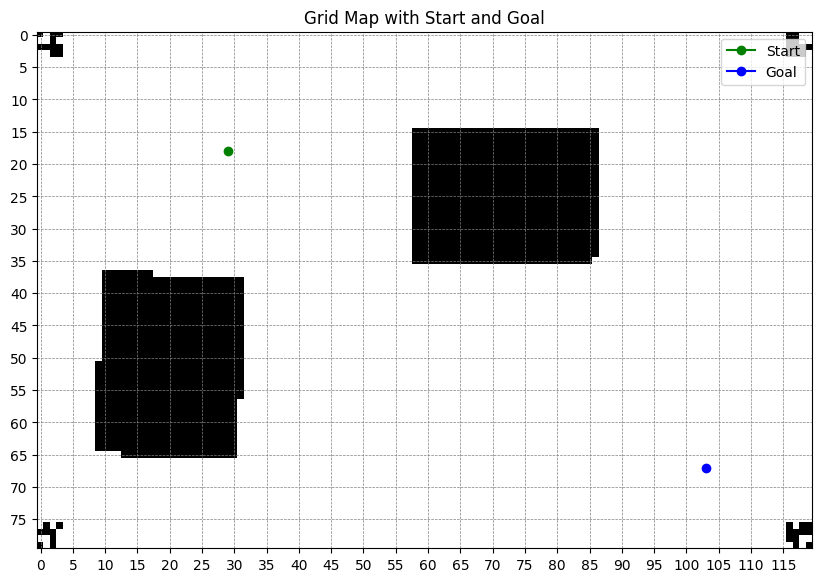

MAIN: reduced path [(18.0, 29.0), (40.0, 51.0), (41.0, 51.0), (67.0, 77.0), (67.0, 103.0)]


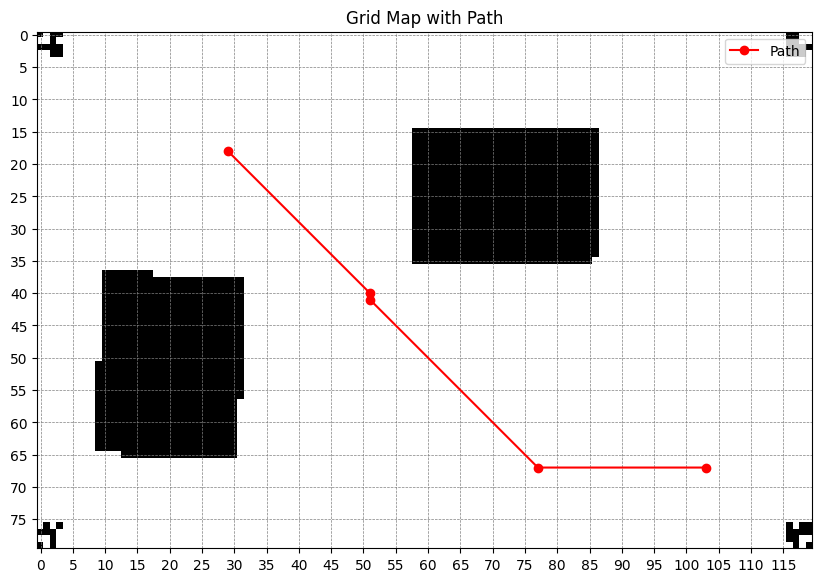

MAIN: iter:  1
MAIN: position:  None
MAIN: angle:  None
MAIN: dt:  0
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  []
THYMIO CONTROL: kidnapping predicted angle:  None
THYMIO CONTROL: kidnapping pos:  [18.0, 29.000000000000004]
THYMIO CONTROL: kidnapping angle:  0.968122476606561
MAIN: kalman position used:  [160.29712755167674, 258.2564832777014]
MAIN: kalman angle used:  0.968122476606561
THYMIO CONTROL: old pos:  [160.29712755167674, 258.2564832777014]
THYMIO CONTROL: old angle:  0.968122476606561
THYMIO CONTROL: pos:  [160.29712755167674, 258.2564832777014]
THYMIO CONTROL: angle:  0.968122476606561
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:  [160.29712755167674, 258.2564832777014]
THYMIO CONTROL: distance:  277.0772389663842
THYMIO CONTROL: waypoint angle:  0.7853998075978113
THYMIO CONTROL: angle:  0.968122476606561
THYMIO CONTROL: angleDistance:  -0.182722669008

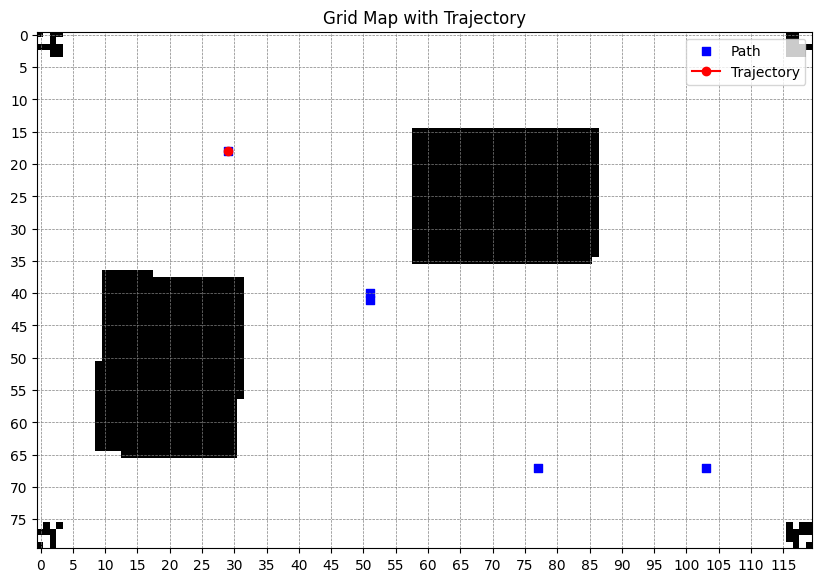

-------------------------------------------------------------------------------------------------
MAIN: iter:  2
MAIN: position:  [160.29712755167674, 258.2564832777014]
MAIN: angle:  0.968122476606561
MAIN: dt:  0.3126789
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [160.29712755167674, 258.2564832777014]
THYMIO CONTROL: kidnapping predicted angle:  0.968122476606561
THYMIO CONTROL: kidnapping pos:  [18.0, 29.000000000000004]
THYMIO CONTROL: kidnapping angle:  0.968122476606561
MAIN: kalman position used:  [160.29712755167674, 258.2564832777014]
MAIN: kalman angle used:  0.968122476606561
THYMIO CONTROL: old pos:  [160.29712755167674, 258.2564832777014]
THYMIO CONTROL: old angle:  0.968122476606561
THYMIO CONTROL: pos:  [160.29712755167674, 258.2564832777014]
THYMIO CONTROL: angle:  0.968122476606561
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:  [160.29712755167674, 2

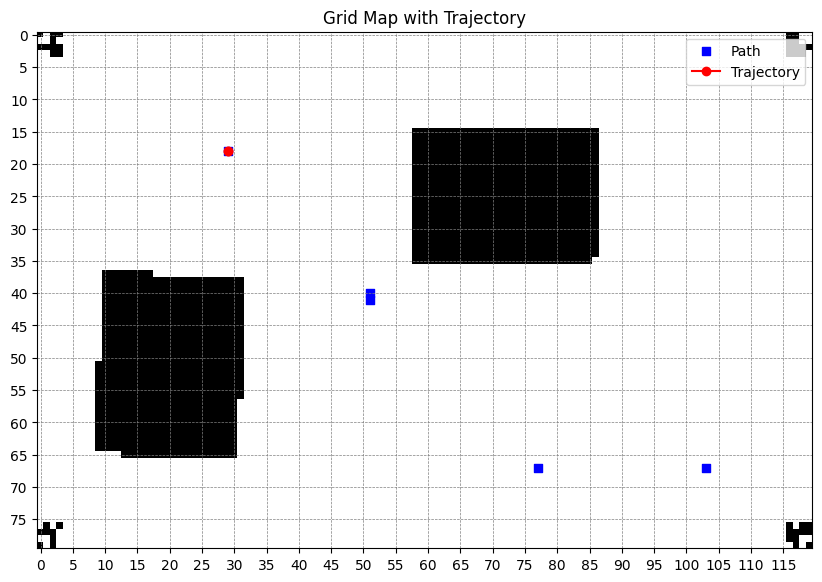

-------------------------------------------------------------------------------------------------
MAIN: iter:  3
MAIN: position:  [160.29712755167674, 258.2564832777014]
MAIN: angle:  0.968122476606561
MAIN: dt:  0.3025249
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [160.29589315794408, 258.2546892815693]
THYMIO CONTROL: kidnapping predicted angle:  0.8982980043983108
THYMIO CONTROL: kidnapping pos:  [17.999861388113892, 28.999798549538156]
THYMIO CONTROL: kidnapping angle:  0.8982980043983108
MAIN: kalman position used:  [160.29589315794408, 258.2546892815693]
MAIN: kalman angle used:  0.8982980043983108
THYMIO CONTROL: old pos:  [160.29589315794408, 258.2546892815693]
THYMIO CONTROL: old angle:  0.8982980043983108
THYMIO CONTROL: pos:  [160.29589315794408, 258.2546892815693]
THYMIO CONTROL: angle:  0.8982980043983108
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:  [16

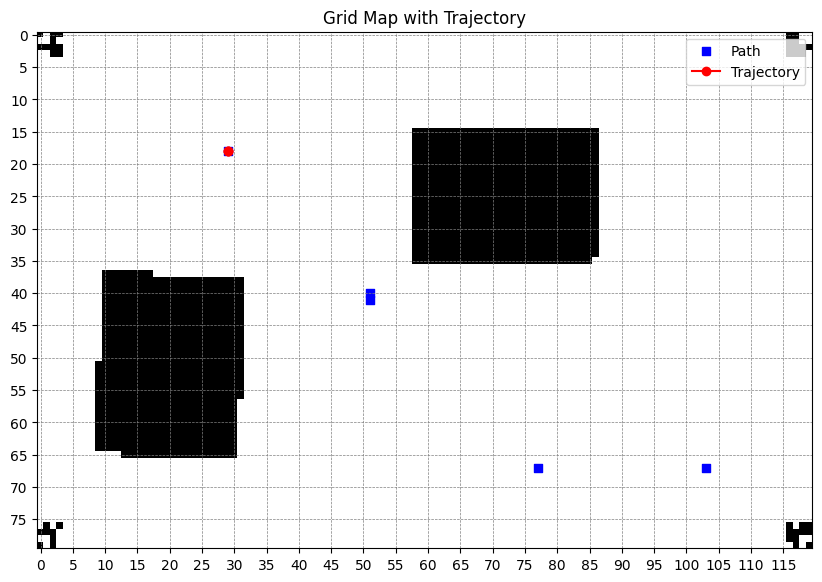

-------------------------------------------------------------------------------------------------
MAIN: iter:  4
MAIN: position:  [160.29589315794408, 258.2546892815693]
MAIN: angle:  0.8982980043983108
MAIN: dt:  0.3653295
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [160.30442438230767, 258.26540247642816]
THYMIO CONTROL: kidnapping predicted angle:  0.855190433242007
THYMIO CONTROL: kidnapping pos:  [18.000819371833813, 29.001001549931267]
THYMIO CONTROL: kidnapping angle:  0.855190433242007
MAIN: kalman position used:  [160.30442438230767, 258.26540247642816]
MAIN: kalman angle used:  0.855190433242007
THYMIO CONTROL: old pos:  [160.30442438230767, 258.26540247642816]
THYMIO CONTROL: old angle:  0.855190433242007
THYMIO CONTROL: pos:  [160.30442438230767, 258.26540247642816]
THYMIO CONTROL: angle:  0.855190433242007
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:  [16

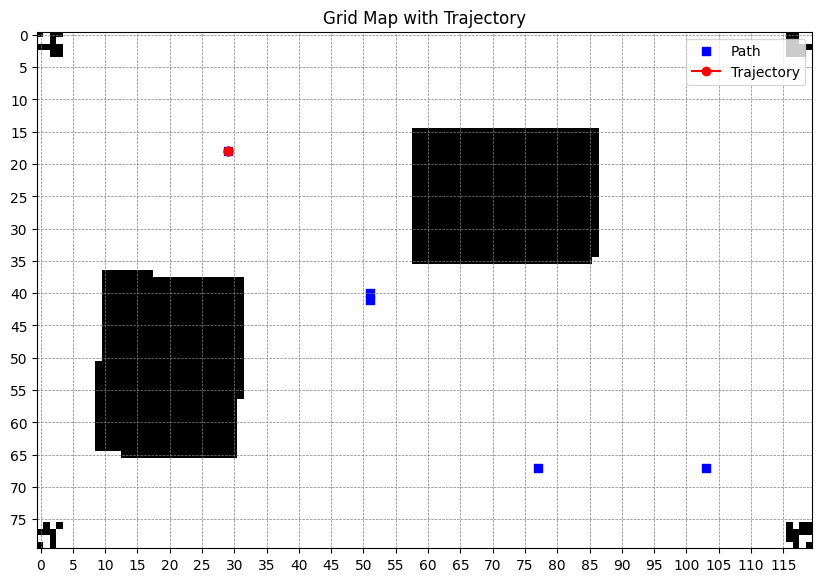

-------------------------------------------------------------------------------------------------
MAIN: iter:  5
MAIN: position:  [160.30442438230767, 258.26540247642816]
MAIN: angle:  0.855190433242007
MAIN: dt:  0.3748587
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [184.24846529578343, 285.8087080255336]
THYMIO CONTROL: kidnapping predicted angle:  0.855516978548699
THYMIO CONTROL: kidnapping pos:  [20.68953091037102, 32.093879803311495]
THYMIO CONTROL: kidnapping angle:  0.855516978548699
MAIN: kalman position used:  [184.24846529578343, 285.8087080255336]
MAIN: kalman angle used:  0.855516978548699
THYMIO CONTROL: old pos:  [184.24846529578343, 285.8087080255336]
THYMIO CONTROL: old angle:  0.855516978548699
THYMIO CONTROL: pos:  [184.24846529578343, 285.8087080255336]
THYMIO CONTROL: angle:  0.855516978548699
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:  [184.248

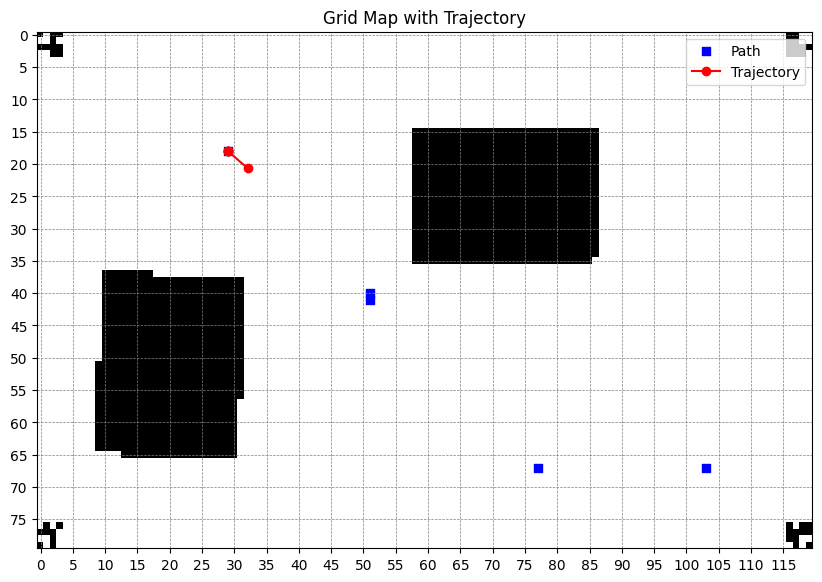

-------------------------------------------------------------------------------------------------
MAIN: iter:  6
MAIN: position:  [184.24846529578343, 285.8087080255336]
MAIN: angle:  0.855516978548699
MAIN: dt:  0.3330204
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [208.80782894018, 314.07847028625986]
THYMIO CONTROL: kidnapping predicted angle:  0.8558520414142975
THYMIO CONTROL: kidnapping pos:  [23.44733794254397, 35.26833294832514]
THYMIO CONTROL: kidnapping angle:  0.8558520414142975
MAIN: kalman position used:  [208.80782894018, 314.07847028625986]
MAIN: kalman angle used:  0.8558520414142975
THYMIO CONTROL: old pos:  [208.80782894018, 314.07847028625986]
THYMIO CONTROL: old angle:  0.8558520414142975
THYMIO CONTROL: pos:  [208.80782894018, 314.07847028625986]
THYMIO CONTROL: angle:  0.8558520414142975
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:  [208.80782894

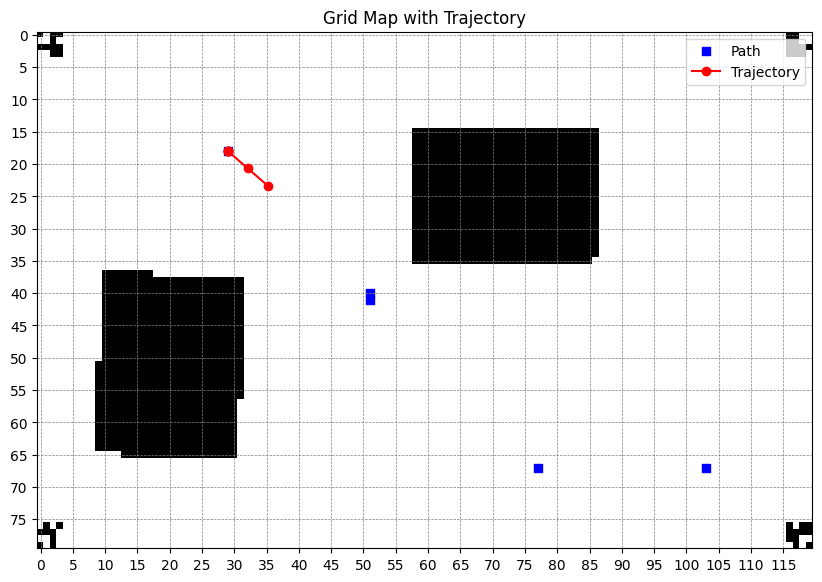

-------------------------------------------------------------------------------------------------
MAIN: iter:  7
MAIN: position:  [208.80782894018, 314.07847028625986]
MAIN: angle:  0.8558520414142975
MAIN: dt:  0.3958088
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [230.61768483305664, 339.20032929411997]
THYMIO CONTROL: kidnapping predicted angle:  0.8561497076269977
THYMIO CONTROL: kidnapping pos:  [25.896398709058456, 38.08930341141534]
THYMIO CONTROL: kidnapping angle:  0.8561497076269977
MAIN: kalman position used:  [230.61768483305664, 339.20032929411997]
MAIN: kalman angle used:  0.8561497076269977
THYMIO CONTROL: old pos:  [230.61768483305664, 339.20032929411997]
THYMIO CONTROL: old angle:  0.8561497076269977
THYMIO CONTROL: pos:  [230.61768483305664, 339.20032929411997]
THYMIO CONTROL: angle:  0.8561497076269977
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:  [

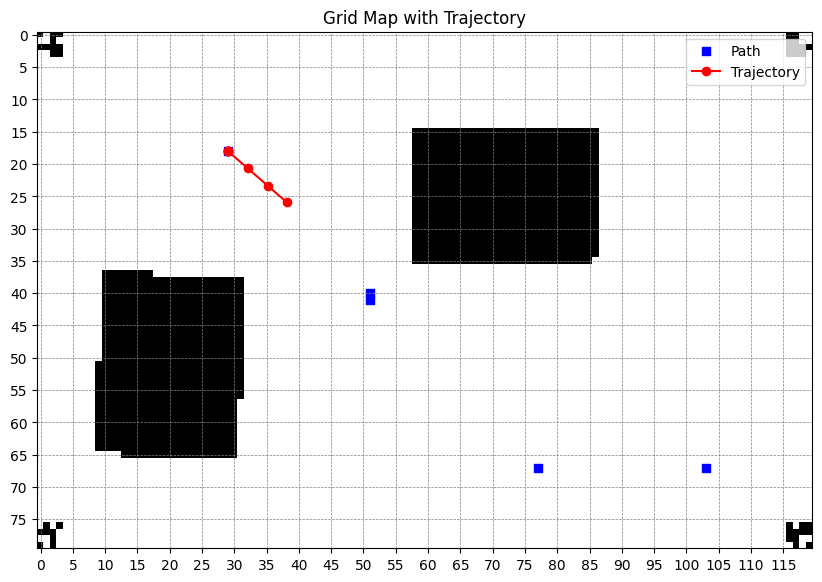

-------------------------------------------------------------------------------------------------
MAIN: iter:  8
MAIN: position:  [230.61768483305664, 339.20032929411997]
MAIN: angle:  0.8561497076269977
MAIN: dt:  0.3606465
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [230.61994301114478, 339.20293195938245]
THYMIO CONTROL: kidnapping predicted angle:  0.8089041541050426
THYMIO CONTROL: kidnapping pos:  [25.896652283194232, 38.08959566852212]
THYMIO CONTROL: kidnapping angle:  0.8089041541050426
MAIN: kalman position used:  [230.61994301114478, 339.20293195938245]
MAIN: kalman angle used:  0.8089041541050426
THYMIO CONTROL: old pos:  [230.61994301114478, 339.20293195938245]
THYMIO CONTROL: old angle:  0.8089041541050426
THYMIO CONTROL: pos:  [230.61994301114478, 339.20293195938245]
THYMIO CONTROL: angle:  0.8089041541050426
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:

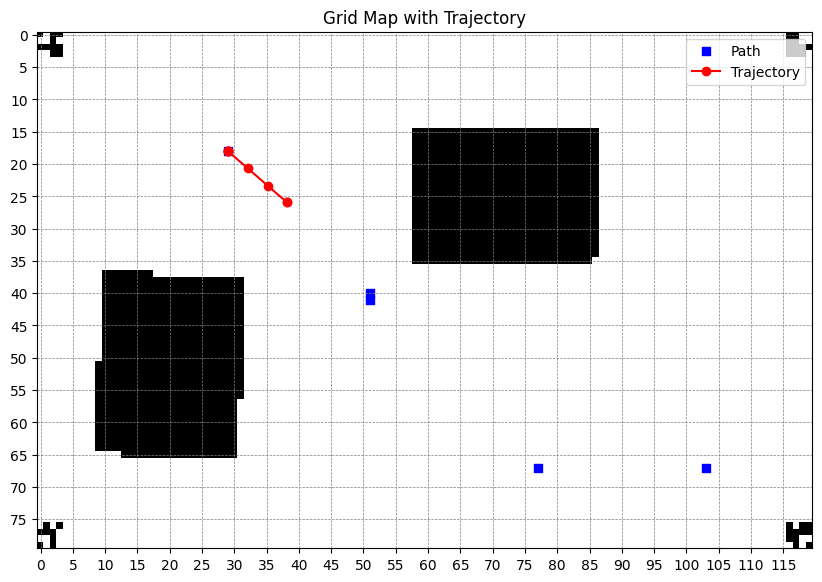

-------------------------------------------------------------------------------------------------
MAIN: iter:  9
MAIN: position:  [230.61994301114478, 339.20293195938245]
MAIN: angle:  0.8089041541050426
MAIN: dt:  0.4441021
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [255.48982558565734, 365.2703672237104]
THYMIO CONTROL: kidnapping predicted angle:  0.8092265135694435
THYMIO CONTROL: kidnapping pos:  [28.689327942319252, 41.01674627891992]
THYMIO CONTROL: kidnapping angle:  0.8092265135694435
MAIN: kalman position used:  [255.48982558565734, 365.2703672237104]
MAIN: kalman angle used:  0.8092265135694435
THYMIO CONTROL: old pos:  [255.48982558565734, 365.2703672237104]
THYMIO CONTROL: old angle:  0.8092265135694435
THYMIO CONTROL: pos:  [255.48982558565734, 365.2703672237104]
THYMIO CONTROL: angle:  0.8092265135694435
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:  [2

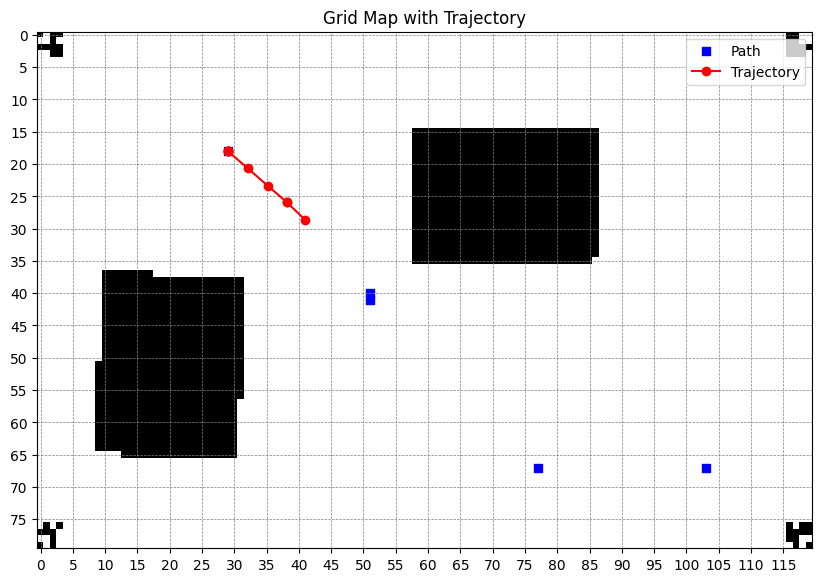

-------------------------------------------------------------------------------------------------
MAIN: iter:  10
MAIN: position:  [255.48982558565734, 365.2703672237104]
MAIN: angle:  0.8092265135694435
MAIN: dt:  0.3139602
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [286.1043877035137, 397.37982212246925]
THYMIO CONTROL: kidnapping predicted angle:  0.809623468801493
THYMIO CONTROL: kidnapping pos:  [32.127082108835815, 44.62236415246124]
THYMIO CONTROL: kidnapping angle:  0.809623468801493
MAIN: kalman position used:  [286.1043877035137, 397.37982212246925]
MAIN: kalman angle used:  0.809623468801493
THYMIO CONTROL: old pos:  [286.1043877035137, 397.37982212246925]
THYMIO CONTROL: old angle:  0.809623468801493
THYMIO CONTROL: pos:  [286.1043877035137, 397.37982212246925]
THYMIO CONTROL: angle:  0.809623468801493
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (356.22, 454.18)
THYMIO CONTROL: pos:  [286.10

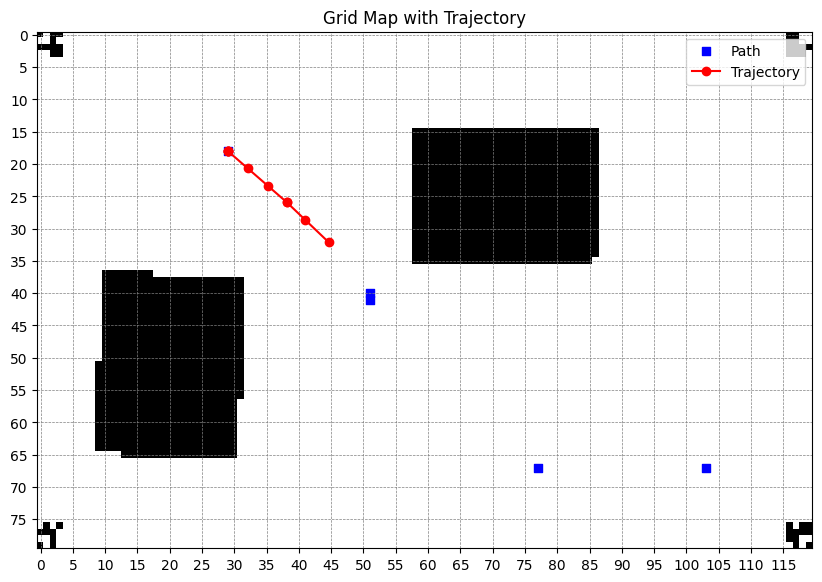

-------------------------------------------------------------------------------------------------
MAIN: iter:  11
MAIN: position:  [286.1043877035137, 397.37982212246925]
MAIN: angle:  0.809623468801493
MAIN: dt:  0.3831243
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [286.1055188788408, 397.3810094758526]
THYMIO CONTROL: kidnapping predicted angle:  0.7370924395710907
THYMIO CONTROL: kidnapping pos:  [32.1272091301755, 44.6224974821174]
THYMIO CONTROL: kidnapping angle:  0.7370924395710907
MAIN: kalman position used:  [286.1055188788408, 397.3810094758526]
MAIN: kalman angle used:  0.7370924395710907
THYMIO CONTROL: old pos:  [286.1055188788408, 397.3810094758526]
THYMIO CONTROL: old angle:  0.7370924395710907
THYMIO CONTROL: pos:  [286.1055188788408, 397.3810094758526]
THYMIO CONTROL: angle:  0.7370924395710907
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (365.12, 454.18)
THYMIO CONTROL: pos:  [286.10551

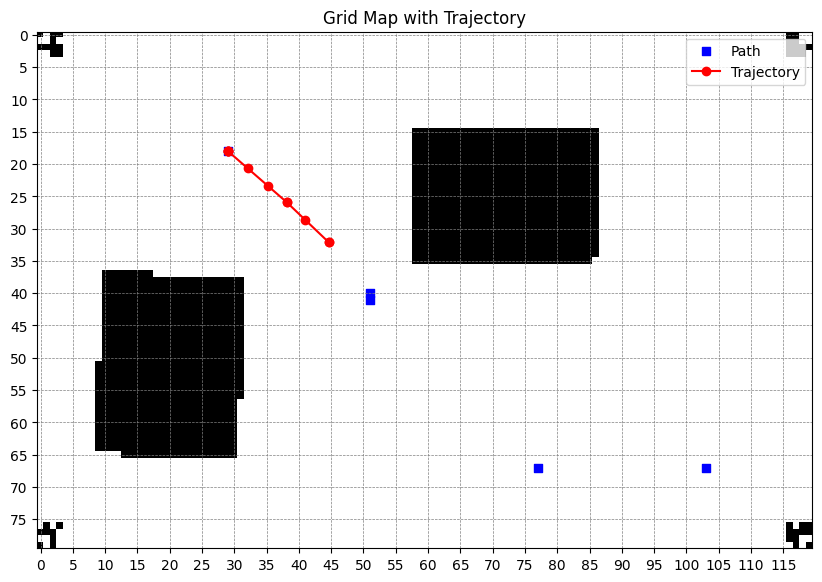

-------------------------------------------------------------------------------------------------
MAIN: iter:  12
MAIN: position:  [286.1055188788408, 397.3810094758526]
MAIN: angle:  0.7370924395710907
MAIN: dt:  0.3787339
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [314.44426854805016, 423.1061314587006]
THYMIO CONTROL: kidnapping predicted angle:  0.7374348905421857
THYMIO CONTROL: kidnapping pos:  [35.30940897266065, 47.51120923112853]
THYMIO CONTROL: kidnapping angle:  0.7374348905421857
MAIN: kalman position used:  [314.44426854805016, 423.1061314587006]
MAIN: kalman angle used:  0.7374348905421857
THYMIO CONTROL: old pos:  [314.44426854805016, 423.1061314587006]
THYMIO CONTROL: old angle:  0.7374348905421857
THYMIO CONTROL: pos:  [314.44426854805016, 423.1061314587006]
THYMIO CONTROL: angle:  0.7374348905421857
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 685.72)
THYMIO CONTROL: pos:  [314

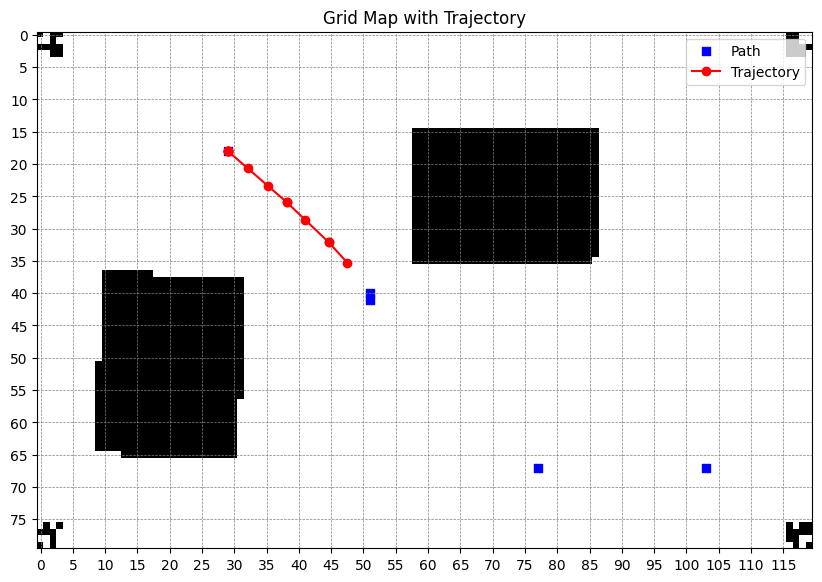

-------------------------------------------------------------------------------------------------
MAIN: iter:  13
MAIN: position:  [314.44426854805016, 423.1061314587006]
MAIN: angle:  0.7374348905421857
MAIN: dt:  0.3589115
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [342.4495609885397, 448.5460492045371]
THYMIO CONTROL: kidnapping predicted angle:  0.7377734172079221
THYMIO CONTROL: kidnapping pos:  [38.454164412937025, 50.367894977274744]
THYMIO CONTROL: kidnapping angle:  0.7377734172079221
MAIN: kalman position used:  [342.4495609885397, 448.5460492045371]
MAIN: kalman angle used:  0.7377734172079221
THYMIO CONTROL: old pos:  [342.4495609885397, 448.5460492045371]
THYMIO CONTROL: old angle:  0.7377734172079221
THYMIO CONTROL: pos:  [342.4495609885397, 448.5460492045371]
THYMIO CONTROL: angle:  0.7377734172079221
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 685.72)
THYMIO CONTROL: pos:  [342.

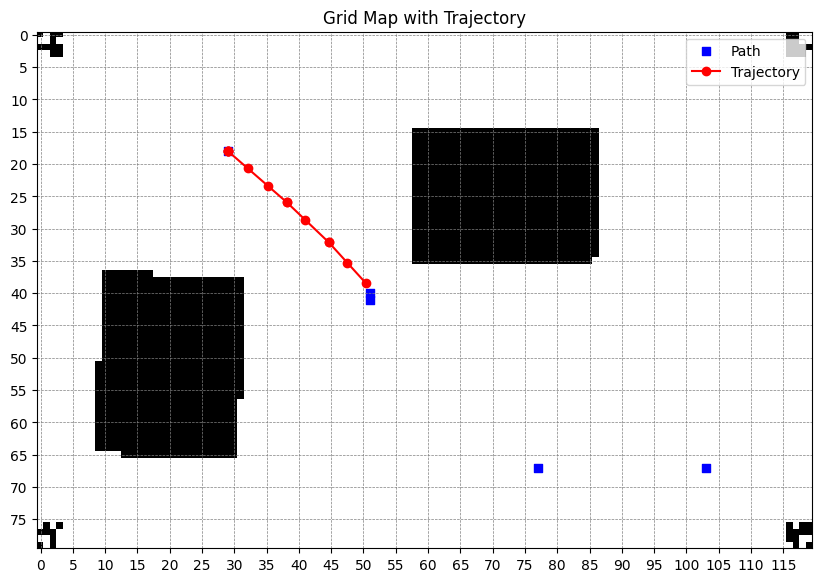

-------------------------------------------------------------------------------------------------
MAIN: iter:  14
MAIN: position:  [342.4495609885397, 448.5460492045371]
MAIN: angle:  0.7377734172079221
MAIN: dt:  0.3293789
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [368.98093291889813, 472.66346037103904]
THYMIO CONTROL: kidnapping predicted angle:  0.7380942258637869
THYMIO CONTROL: kidnapping pos:  [41.43341115329109, 53.07607451628168]
THYMIO CONTROL: kidnapping angle:  0.7380942258637869
MAIN: kalman position used:  [368.98093291889813, 472.66346037103904]
MAIN: kalman angle used:  0.7380942258637869
THYMIO CONTROL: old pos:  [368.98093291889813, 472.66346037103904]
THYMIO CONTROL: old angle:  0.7380942258637869
THYMIO CONTROL: pos:  [368.98093291889813, 472.66346037103904]
THYMIO CONTROL: angle:  0.7380942258637869
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 685.72)
THYMIO CONTROL: pos:  

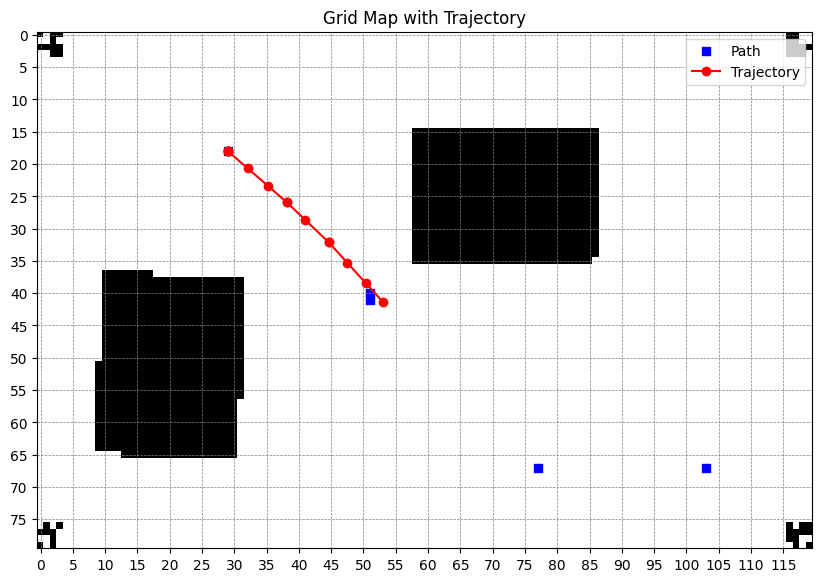

-------------------------------------------------------------------------------------------------
MAIN: iter:  15
MAIN: position:  [368.98093291889813, 472.66346037103904]
MAIN: angle:  0.7380942258637869
MAIN: dt:  0.3743363
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [393.3221012103927, 494.8042094373058]
THYMIO CONTROL: kidnapping predicted angle:  0.7383886371662368
THYMIO CONTROL: kidnapping pos:  [44.166716708661404, 55.56229176346424]
THYMIO CONTROL: kidnapping angle:  0.7383886371662368
MAIN: kalman position used:  [393.3221012103927, 494.8042094373058]
MAIN: kalman angle used:  0.7383886371662368
THYMIO CONTROL: old pos:  [393.3221012103927, 494.8042094373058]
THYMIO CONTROL: old angle:  0.7383886371662368
THYMIO CONTROL: pos:  [393.3221012103927, 494.8042094373058]
THYMIO CONTROL: angle:  0.7383886371662368
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 685.72)
THYMIO CONTROL: pos:  [393.

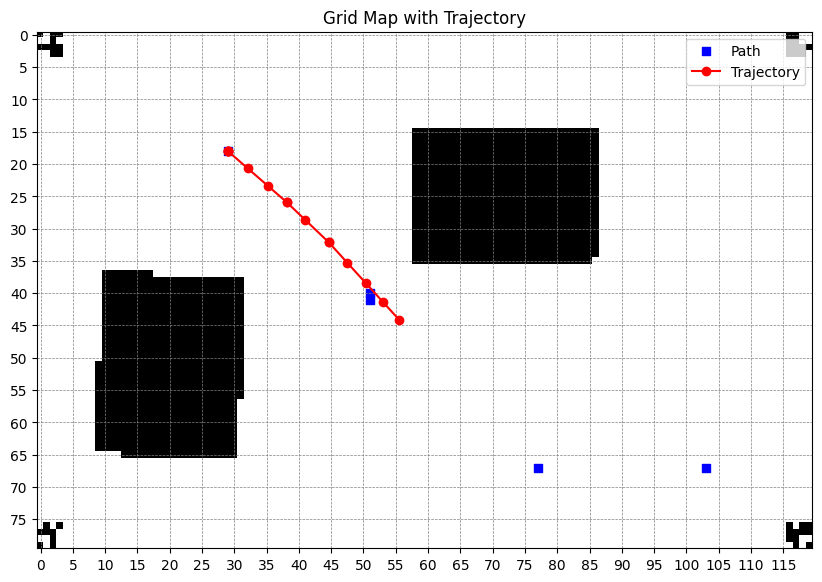

-------------------------------------------------------------------------------------------------
MAIN: iter:  16
MAIN: position:  [393.3221012103927, 494.8042094373058]
MAIN: angle:  0.7383886371662368
MAIN: dt:  0.3469243
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [420.9782211829714, 519.9751245667288]
THYMIO CONTROL: kidnapping predicted angle:  0.7387232330909826
THYMIO CONTROL: kidnapping pos:  [47.27226305942762, 58.38877081052983]
THYMIO CONTROL: kidnapping angle:  0.7387232330909826
MAIN: kalman position used:  [420.9782211829714, 519.9751245667288]
MAIN: kalman angle used:  0.7387232330909826
THYMIO CONTROL: old pos:  [420.9782211829714, 519.9751245667288]
THYMIO CONTROL: old angle:  0.7387232330909826
THYMIO CONTROL: pos:  [420.9782211829714, 519.9751245667288]
THYMIO CONTROL: angle:  0.7387232330909826
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 685.72)
THYMIO CONTROL: pos:  [420.978

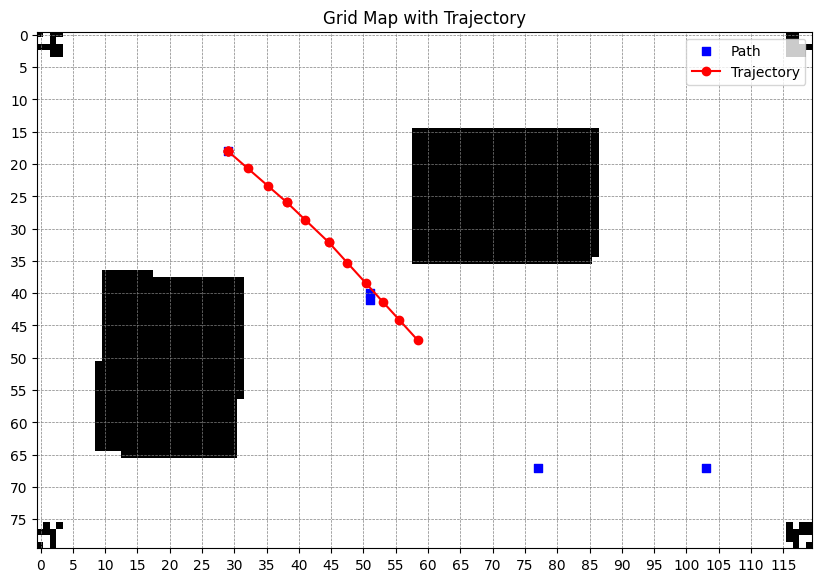

-------------------------------------------------------------------------------------------------
MAIN: iter:  17
MAIN: position:  [420.9782211829714, 519.9751245667288]
MAIN: angle:  0.7387232330909826
MAIN: dt:  0.3838283
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [446.6013245235231, 543.3113917952811]
THYMIO CONTROL: kidnapping predicted angle:  0.7390333271346949
THYMIO CONTROL: kidnapping pos:  [50.14951898518489, 61.009234548899215]
THYMIO CONTROL: kidnapping angle:  0.7390333271346949
MAIN: kalman position used:  [446.6013245235231, 543.3113917952811]
MAIN: kalman angle used:  0.7390333271346949
THYMIO CONTROL: old pos:  [446.6013245235231, 543.3113917952811]
THYMIO CONTROL: old angle:  0.7390333271346949
THYMIO CONTROL: pos:  [446.6013245235231, 543.3113917952811]
THYMIO CONTROL: angle:  0.7390333271346949
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 685.72)
THYMIO CONTROL: pos:  [446.60

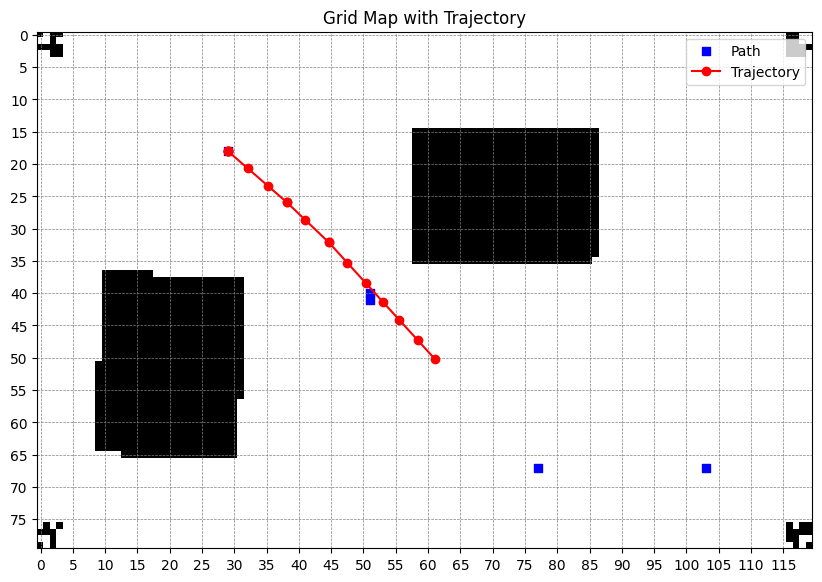

-------------------------------------------------------------------------------------------------
MAIN: iter:  18
MAIN: position:  [446.6013245235231, 543.3113917952811]
MAIN: angle:  0.7390333271346949
MAIN: dt:  0.4356081
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [474.9420725588386, 569.1388391181406]
THYMIO CONTROL: kidnapping predicted angle:  0.7393764073675821
THYMIO CONTROL: kidnapping pos:  [53.331943227136584, 63.909436560701316]
THYMIO CONTROL: kidnapping angle:  0.7393764073675821
MAIN: kalman position used:  [474.9420725588386, 569.1388391181406]
MAIN: kalman angle used:  0.7393764073675821
THYMIO CONTROL: old pos:  [474.9420725588386, 569.1388391181406]
THYMIO CONTROL: old angle:  0.7393764073675821
THYMIO CONTROL: pos:  [474.9420725588386, 569.1388391181406]
THYMIO CONTROL: angle:  0.7393764073675821
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 685.72)
THYMIO CONTROL: pos:  [474.9

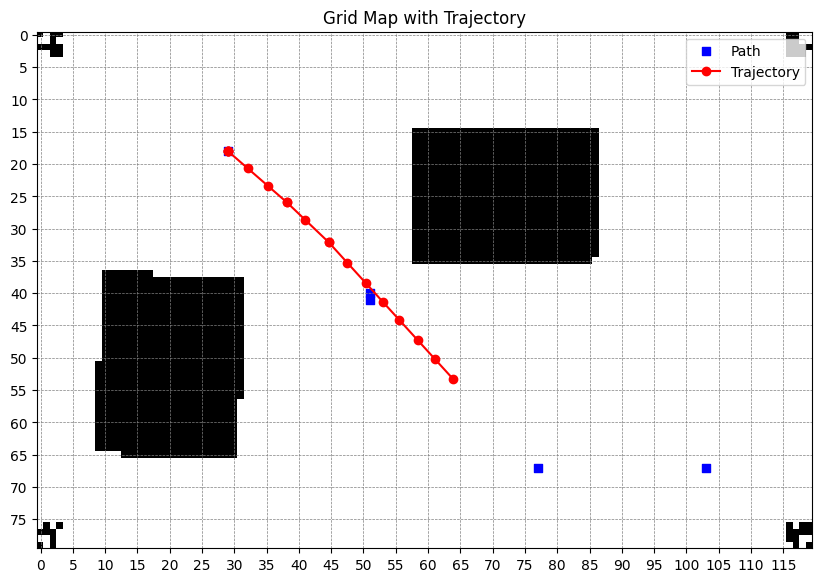

-------------------------------------------------------------------------------------------------
MAIN: iter:  19
MAIN: position:  [474.9420725588386, 569.1388391181406]
MAIN: angle:  0.7393764073675821
MAIN: dt:  0.4668737
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [507.0960299501211, 598.4615338674389]
THYMIO CONTROL: kidnapping predicted angle:  0.7397657703415879
THYMIO CONTROL: kidnapping pos:  [56.94255835095719, 67.20212504207922]
THYMIO CONTROL: kidnapping angle:  0.7397657703415879
MAIN: kalman position used:  [507.0960299501211, 598.4615338674389]
MAIN: kalman angle used:  0.7397657703415879
THYMIO CONTROL: old pos:  [507.0960299501211, 598.4615338674389]
THYMIO CONTROL: old angle:  0.7397657703415879
THYMIO CONTROL: pos:  [507.0960299501211, 598.4615338674389]
THYMIO CONTROL: angle:  0.7397657703415879
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 685.72)
THYMIO CONTROL: pos:  [507.096

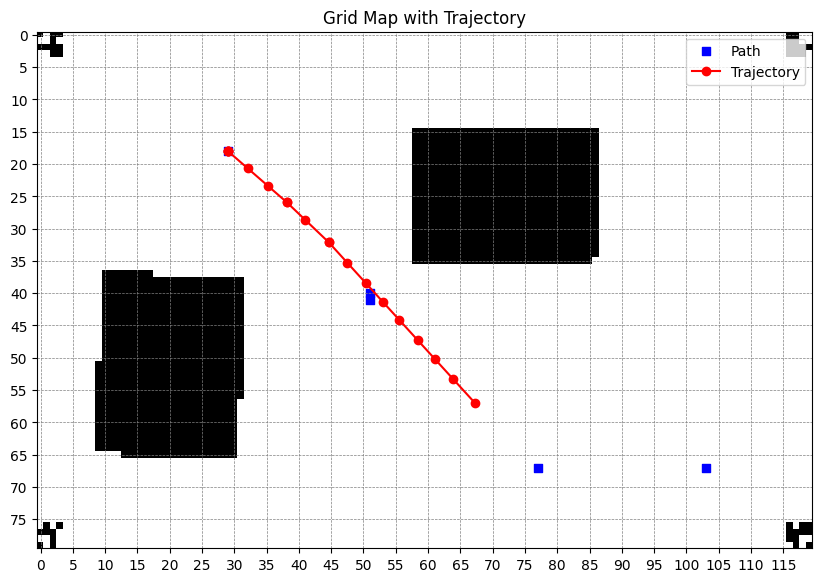

-------------------------------------------------------------------------------------------------
MAIN: iter:  20
MAIN: position:  [507.0960299501211, 598.4615338674389]
MAIN: angle:  0.7397657703415879
MAIN: dt:  0.3544217
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [541.5455857365203, 629.9022692606142]
THYMIO CONTROL: kidnapping predicted angle:  0.7401830796898691
THYMIO CONTROL: kidnapping pos:  [60.81094959181258, 70.73265141969449]
THYMIO CONTROL: kidnapping angle:  0.7401830796898691
MAIN: kalman position used:  [541.5455857365203, 629.9022692606142]
MAIN: kalman angle used:  0.7401830796898691
THYMIO CONTROL: old pos:  [541.5455857365203, 629.9022692606142]
THYMIO CONTROL: old angle:  0.7401830796898691
THYMIO CONTROL: pos:  [541.5455857365203, 629.9022692606142]
THYMIO CONTROL: angle:  0.7401830796898691
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 685.72)
THYMIO CONTROL: pos:  [541.545

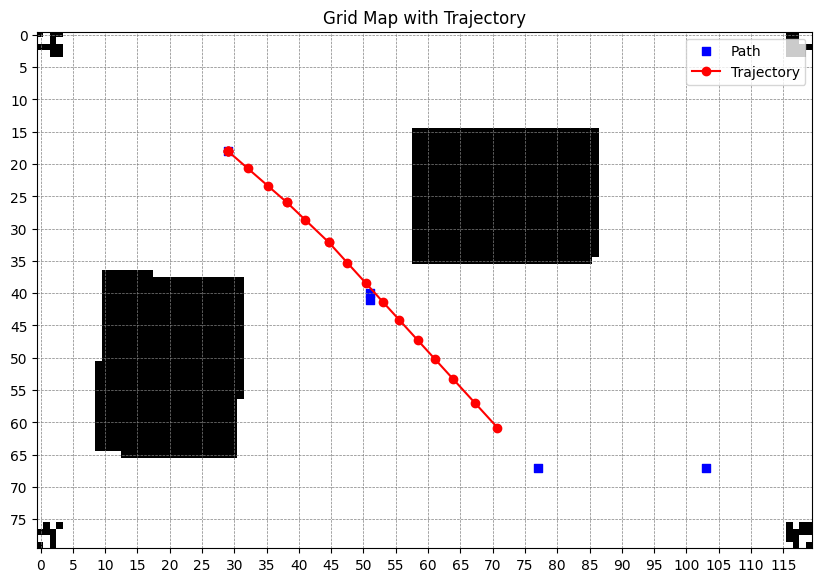

-------------------------------------------------------------------------------------------------
MAIN: iter:  21
MAIN: position:  [541.5455857365203, 629.9022692606142]
MAIN: angle:  0.7401830796898691
MAIN: dt:  0.3801733
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [541.5255381796618, 629.8839573148043]
THYMIO CONTROL: kidnapping predicted angle:  0.9994801989212629
THYMIO CONTROL: kidnapping pos:  [60.80869842219423, 70.73059514439117]
THYMIO CONTROL: kidnapping angle:  0.9994801989212629
MAIN: kalman position used:  [541.5255381796618, 629.8839573148043]
MAIN: kalman angle used:  0.9994801989212629
THYMIO CONTROL: old pos:  [541.5255381796618, 629.8839573148043]
THYMIO CONTROL: old angle:  0.9994801989212629
THYMIO CONTROL: pos:  [541.5255381796618, 629.8839573148043]
THYMIO CONTROL: angle:  0.9994801989212629
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [541.525

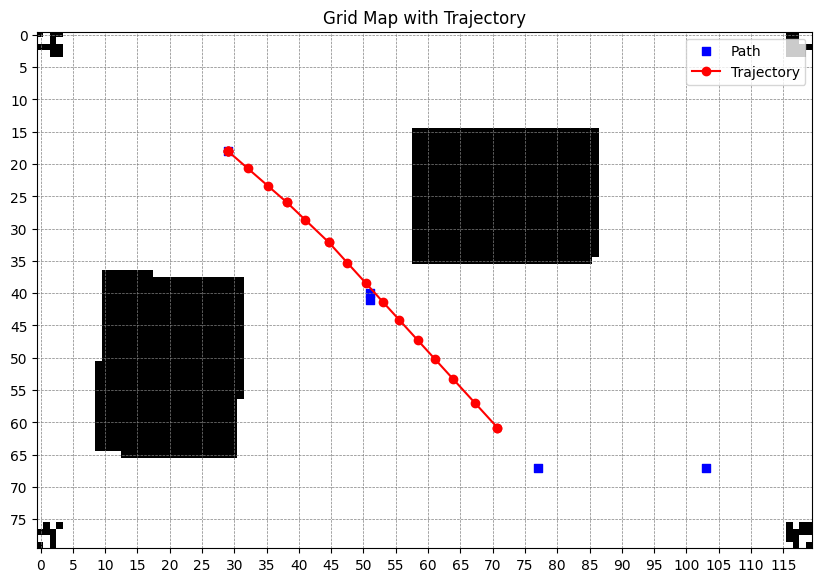

-------------------------------------------------------------------------------------------------
MAIN: iter:  22
MAIN: position:  [541.5255381796618, 629.8839573148043]
MAIN: angle:  0.9994801989212629
MAIN: dt:  0.4528796
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [541.5026306180323, 629.8483216573176]
THYMIO CONTROL: kidnapping predicted angle:  1.1561341098574536
THYMIO CONTROL: kidnapping pos:  [60.80612609843754, 70.72659356404748]
THYMIO CONTROL: kidnapping angle:  1.1561341098574536
MAIN: kalman position used:  [541.5026306180323, 629.8483216573176]
MAIN: kalman angle used:  1.1561341098574536
THYMIO CONTROL: old pos:  [541.5026306180323, 629.8483216573176]
THYMIO CONTROL: old angle:  1.1561341098574536
THYMIO CONTROL: pos:  [541.5026306180323, 629.8483216573176]
THYMIO CONTROL: angle:  1.1561341098574536
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [541.502

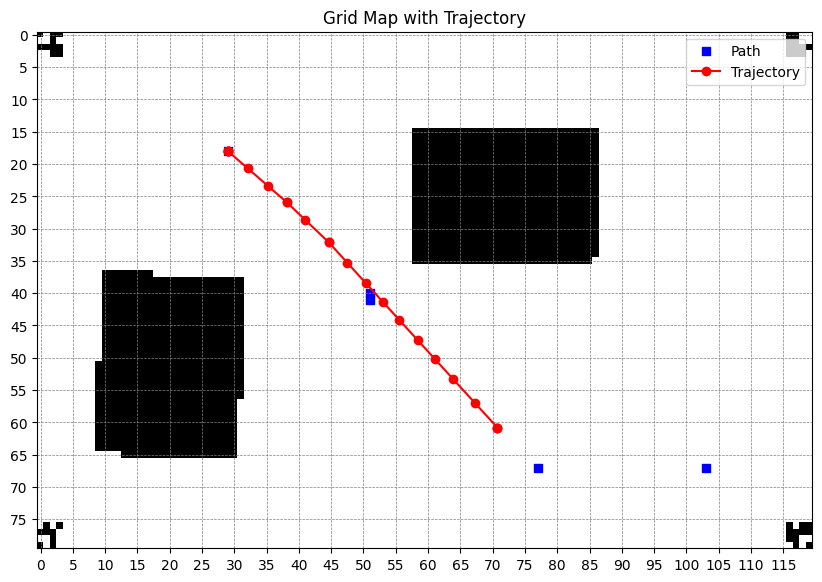

-------------------------------------------------------------------------------------------------
MAIN: iter:  23
MAIN: position:  [541.5026306180323, 629.8483216573176]
MAIN: angle:  1.1561341098574536
MAIN: dt:  0.3881883
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [541.5061250861928, 629.8562602848319]
THYMIO CONTROL: kidnapping predicted angle:  1.253775458614457
THYMIO CONTROL: kidnapping pos:  [60.8065184974022, 70.72748500419641]
THYMIO CONTROL: kidnapping angle:  1.253775458614457
MAIN: kalman position used:  [541.5061250861928, 629.8562602848319]
MAIN: kalman angle used:  1.253775458614457
THYMIO CONTROL: old pos:  [541.5061250861928, 629.8562602848319]
THYMIO CONTROL: old angle:  1.253775458614457
THYMIO CONTROL: pos:  [541.5061250861928, 629.8562602848319]
THYMIO CONTROL: angle:  1.253775458614457
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [541.506125086

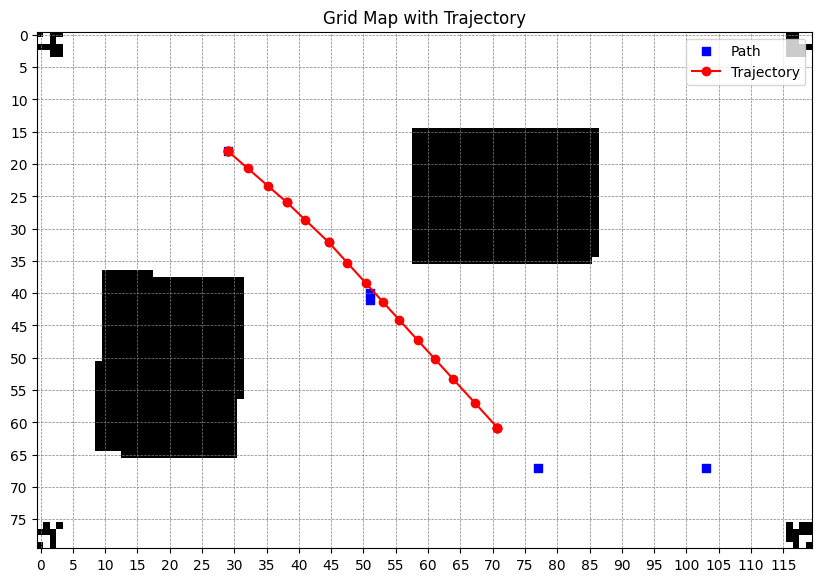

-------------------------------------------------------------------------------------------------
MAIN: iter:  24
MAIN: position:  [541.5061250861928, 629.8562602848319]
MAIN: angle:  1.253775458614457
MAIN: dt:  0.4277465
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [541.5021218257098, 629.844058435022]
THYMIO CONTROL: kidnapping predicted angle:  1.306096753865496
THYMIO CONTROL: kidnapping pos:  [60.8060689654, 70.72611484055135]
THYMIO CONTROL: kidnapping angle:  1.306096753865496
MAIN: kalman position used:  [541.5021218257098, 629.844058435022]
MAIN: kalman angle used:  1.306096753865496
THYMIO CONTROL: old pos:  [541.5021218257098, 629.844058435022]
THYMIO CONTROL: old angle:  1.306096753865496
THYMIO CONTROL: pos:  [541.5021218257098, 629.844058435022]
THYMIO CONTROL: angle:  1.306096753865496
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [541.5021218257098, 62

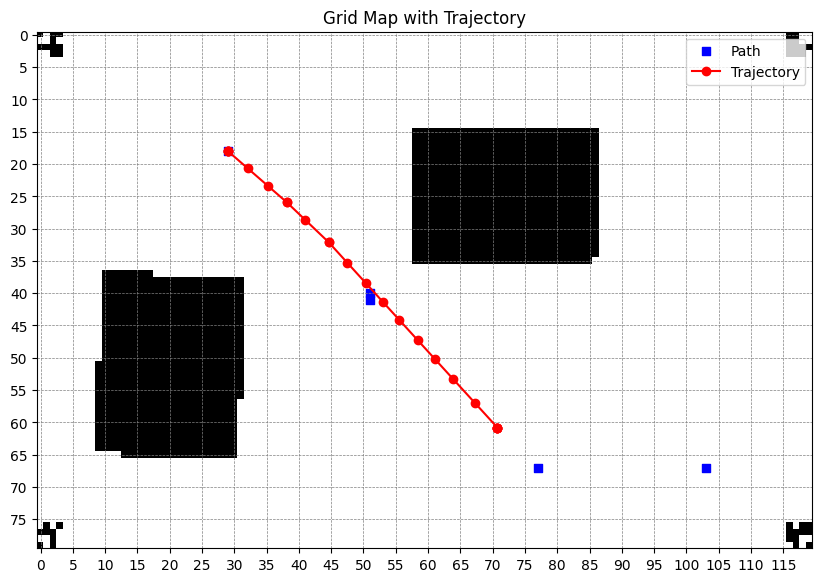

-------------------------------------------------------------------------------------------------
MAIN: iter:  25
MAIN: position:  [541.5021218257098, 629.844058435022]
MAIN: angle:  1.306096753865496
MAIN: dt:  0.3314245
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [552.681447710539, 671.0870479749693]
THYMIO CONTROL: kidnapping predicted angle:  1.3064790898444654
THYMIO CONTROL: kidnapping pos:  [62.06141189637083, 75.3573507401449]
THYMIO CONTROL: kidnapping angle:  1.3064790898444654
MAIN: kalman position used:  [552.681447710539, 671.0870479749693]
MAIN: kalman angle used:  1.3064790898444654
THYMIO CONTROL: old pos:  [552.681447710539, 671.0870479749693]
THYMIO CONTROL: old angle:  1.3064790898444654
THYMIO CONTROL: pos:  [552.681447710539, 671.0870479749693]
THYMIO CONTROL: angle:  1.3064790898444654
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [552.6814477105

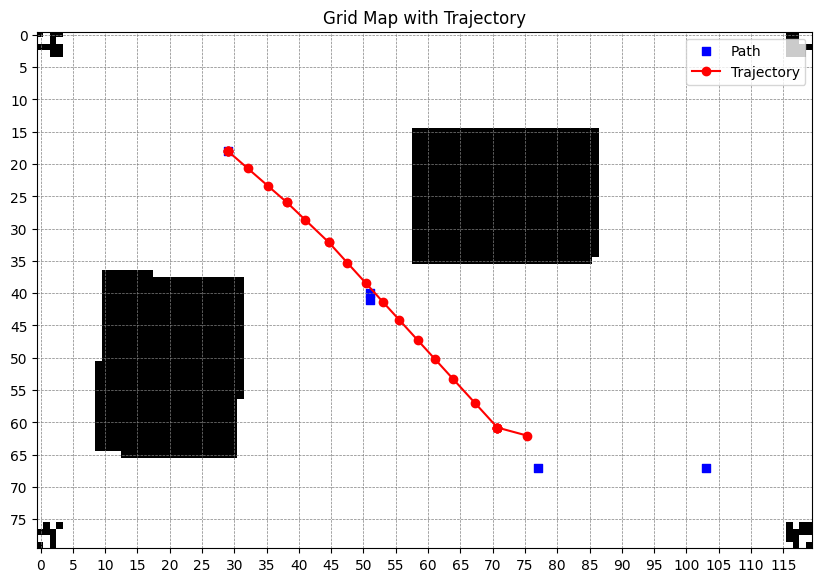

-------------------------------------------------------------------------------------------------
MAIN: iter:  26
MAIN: position:  [552.681447710539, 671.0870479749693]
MAIN: angle:  1.3064790898444654
MAIN: dt:  0.4152041
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [561.3311411494233, 703.046053558108]
THYMIO CONTROL: kidnapping predicted angle:  1.3067753295814637
THYMIO CONTROL: kidnapping pos:  [63.03269868284006, 78.9460744389588]
THYMIO CONTROL: kidnapping angle:  1.3067753295814637
MAIN: kalman position used:  [561.3311411494233, 703.046053558108]
MAIN: kalman angle used:  1.3067753295814637
THYMIO CONTROL: old pos:  [561.3311411494233, 703.046053558108]
THYMIO CONTROL: old angle:  1.3067753295814637
THYMIO CONTROL: pos:  [561.3311411494233, 703.046053558108]
THYMIO CONTROL: angle:  1.3067753295814637
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [561.331141149

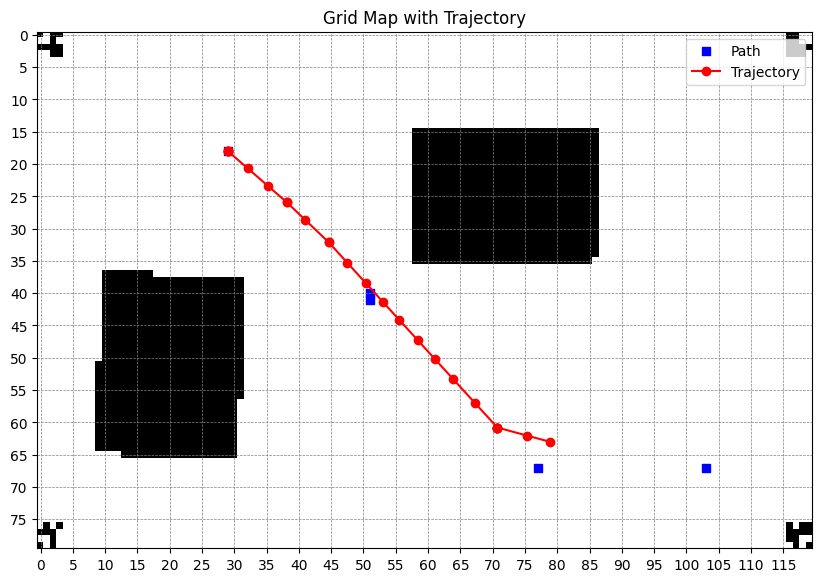

-------------------------------------------------------------------------------------------------
MAIN: iter:  27
MAIN: position:  [561.3311411494233, 703.046053558108]
MAIN: angle:  1.3067753295814637
MAIN: dt:  0.3737645
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [561.3341596538509, 703.0572194854124]
THYMIO CONTROL: kidnapping predicted angle:  1.346733132885321
THYMIO CONTROL: kidnapping pos:  [63.03303763513775, 78.94732827734347]
THYMIO CONTROL: kidnapping angle:  1.346733132885321
MAIN: kalman position used:  [561.3341596538509, 703.0572194854124]
MAIN: kalman angle used:  1.346733132885321
THYMIO CONTROL: old pos:  [561.3341596538509, 703.0572194854124]
THYMIO CONTROL: old angle:  1.346733132885321
THYMIO CONTROL: pos:  [561.3341596538509, 703.0572194854124]
THYMIO CONTROL: angle:  1.346733132885321
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [561.334159653

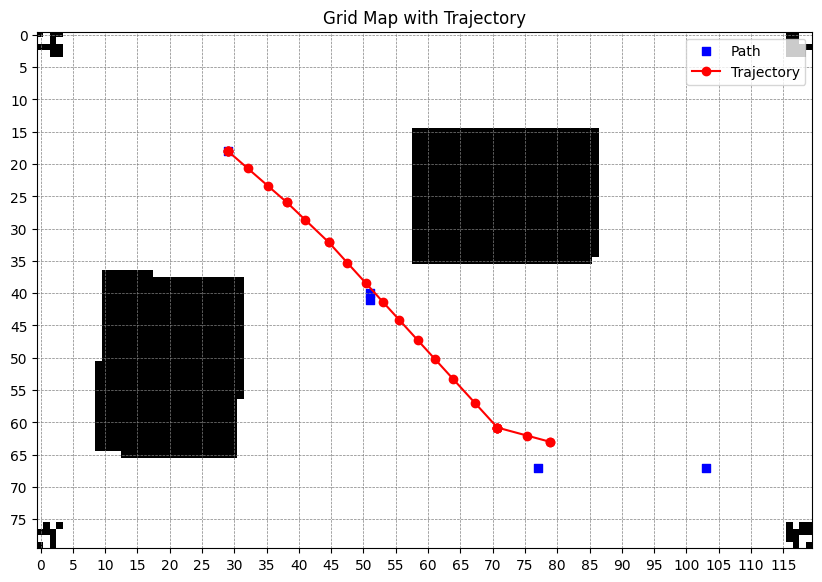

-------------------------------------------------------------------------------------------------
MAIN: iter:  28
MAIN: position:  [561.3341596538509, 703.0572194854124]
MAIN: angle:  1.346733132885321
MAIN: dt:  0.3674646
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [569.6305257321229, 739.4624015572804]
THYMIO CONTROL: kidnapping predicted angle:  1.3470672177136283
THYMIO CONTROL: kidnapping pos:  [63.96464877309002, 83.03531966747222]
THYMIO CONTROL: kidnapping angle:  1.3470672177136283
MAIN: kalman position used:  [569.6305257321229, 739.4624015572804]
MAIN: kalman angle used:  1.3470672177136283
THYMIO CONTROL: old pos:  [569.6305257321229, 739.4624015572804]
THYMIO CONTROL: old angle:  1.3470672177136283
THYMIO CONTROL: pos:  [569.6305257321229, 739.4624015572804]
THYMIO CONTROL: angle:  1.3470672177136283
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [569.6305

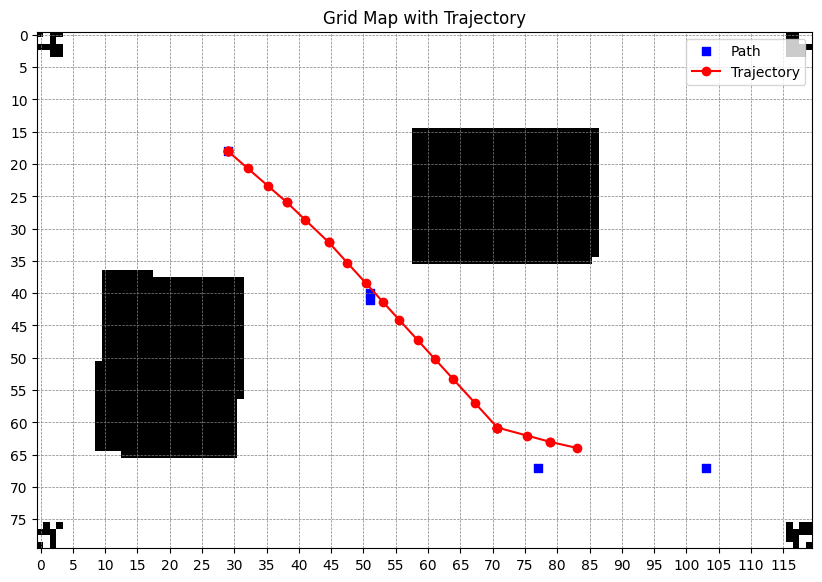

-------------------------------------------------------------------------------------------------
MAIN: iter:  29
MAIN: position:  [569.6305257321229, 739.4624015572804]
MAIN: angle:  1.3470672177136283
MAIN: dt:  0.4231674
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [577.7750964816804, 775.2566875832732]
THYMIO CONTROL: kidnapping predicted angle:  1.3473956714533493
THYMIO CONTROL: kidnapping pos:  [64.8792145905266, 87.05471264293377]
THYMIO CONTROL: kidnapping angle:  1.3473956714533493
MAIN: kalman position used:  [577.7750964816804, 775.2566875832732]
MAIN: kalman angle used:  1.3473956714533493
THYMIO CONTROL: old pos:  [577.7750964816804, 775.2566875832732]
THYMIO CONTROL: old angle:  1.3473956714533493
THYMIO CONTROL: pos:  [577.7750964816804, 775.2566875832732]
THYMIO CONTROL: angle:  1.3473956714533493
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [577.7750

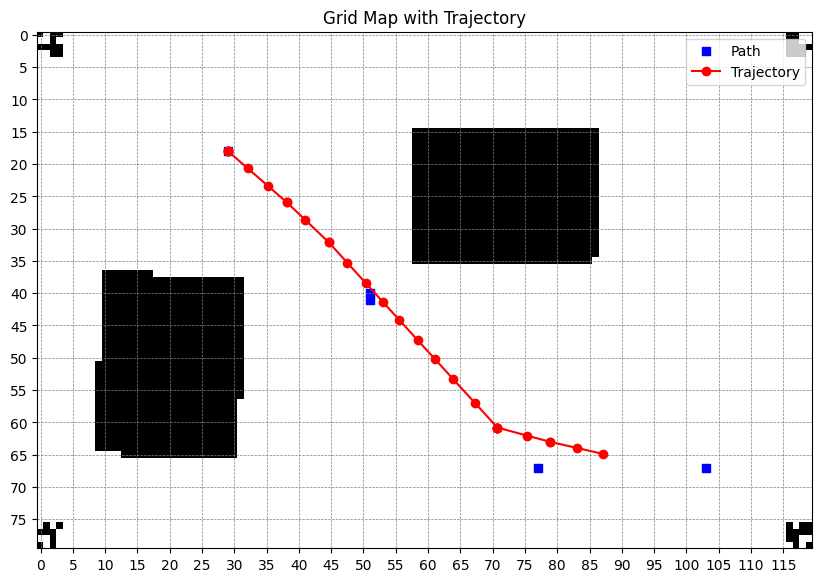

-------------------------------------------------------------------------------------------------
MAIN: iter:  30
MAIN: position:  [577.7750964816804, 775.2566875832732]
MAIN: angle:  1.3473956714533493
MAIN: dt:  0.3454611
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [587.1407375851196, 816.4799949624186]
THYMIO CONTROL: kidnapping predicted angle:  1.3477739144597722
THYMIO CONTROL: kidnapping pos:  [65.93089619229178, 91.68373840376908]
THYMIO CONTROL: kidnapping angle:  1.3477739144597722
MAIN: kalman position used:  [587.1407375851196, 816.4799949624186]
MAIN: kalman angle used:  1.3477739144597722
THYMIO CONTROL: old pos:  [587.1407375851196, 816.4799949624186]
THYMIO CONTROL: old angle:  1.3477739144597722
THYMIO CONTROL: pos:  [587.1407375851196, 816.4799949624186]
THYMIO CONTROL: angle:  1.3477739144597722
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [587.140

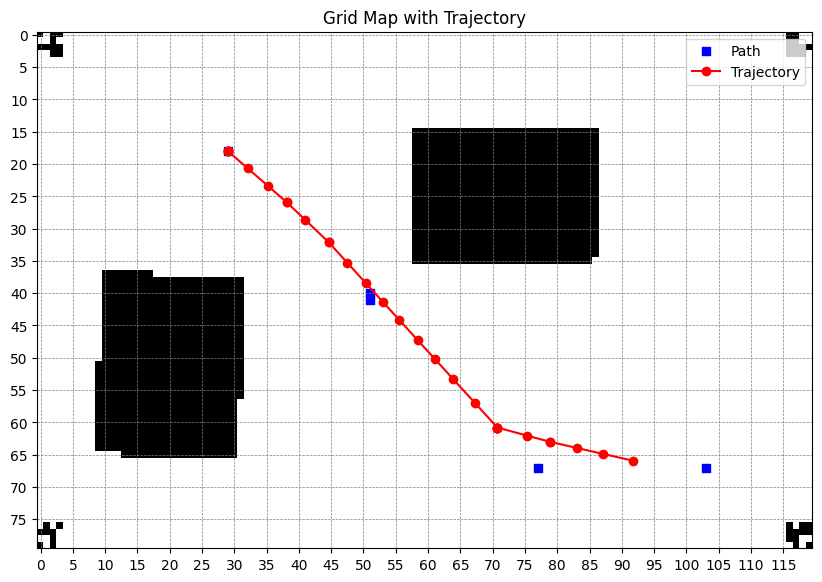

-------------------------------------------------------------------------------------------------
MAIN: iter:  31
MAIN: position:  [587.1407375851196, 816.4799949624186]
MAIN: angle:  1.3477739144597722
MAIN: dt:  0.3318936
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [587.1505822795582, 816.5234028369357]
THYMIO CONTROL: kidnapping predicted angle:  1.3982861871177121
THYMIO CONTROL: kidnapping pos:  [65.9320016674965, 91.68861273778393]
THYMIO CONTROL: kidnapping angle:  1.3982861871177121
MAIN: kalman position used:  [587.1505822795582, 816.5234028369357]
MAIN: kalman angle used:  1.3982861871177121
THYMIO CONTROL: old pos:  [587.1505822795582, 816.5234028369357]
THYMIO CONTROL: old angle:  1.3982861871177121
THYMIO CONTROL: pos:  [587.1505822795582, 816.5234028369357]
THYMIO CONTROL: angle:  1.3982861871177121
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [587.1505

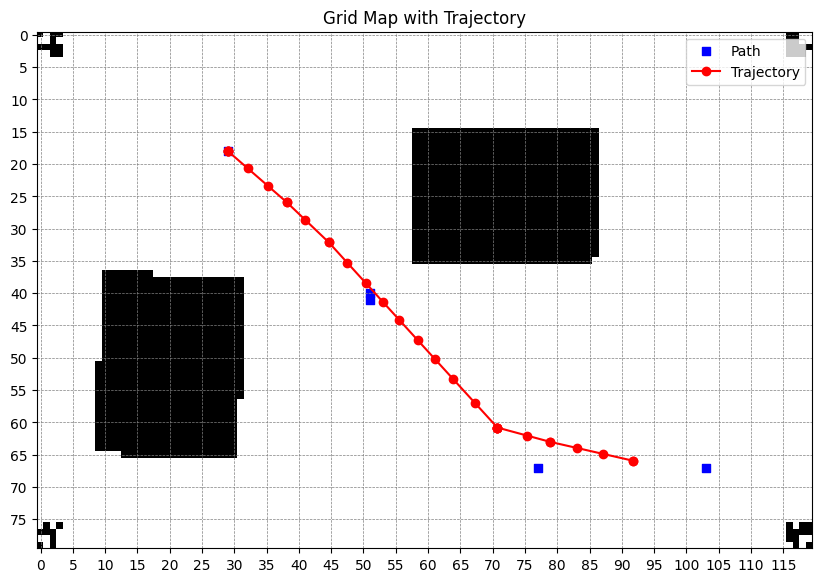

-------------------------------------------------------------------------------------------------
MAIN: iter:  32
MAIN: position:  [587.1505822795582, 816.5234028369357]
MAIN: angle:  1.3982861871177121
MAIN: dt:  0.374015
MAIN: Camera not obstructed, getting position from camera
THYMIO CONTROL: kidnapping predicted pos:  [592.8419497392858, 849.1869741068571]
THYMIO CONTROL: kidnapping predicted angle:  1.3985828461540097
THYMIO CONTROL: kidnapping pos:  [66.5710936826798, 95.35645315288458]
THYMIO CONTROL: kidnapping angle:  1.3985828461540097
MAIN: kalman position used:  [592.8419497392858, 849.1869741068571]
MAIN: kalman angle used:  1.3985828461540097
THYMIO CONTROL: old pos:  [592.8419497392858, 849.1869741068571]
THYMIO CONTROL: old angle:  1.3985828461540097
THYMIO CONTROL: pos:  [592.8419497392858, 849.1869741068571]
THYMIO CONTROL: angle:  1.3985828461540097
MAIN: proximity sensors:  [0, 0, 0, 0, 0]
THYMIO CONTROL: objective:  (596.66, 917.26)
THYMIO CONTROL: pos:  [592.84194

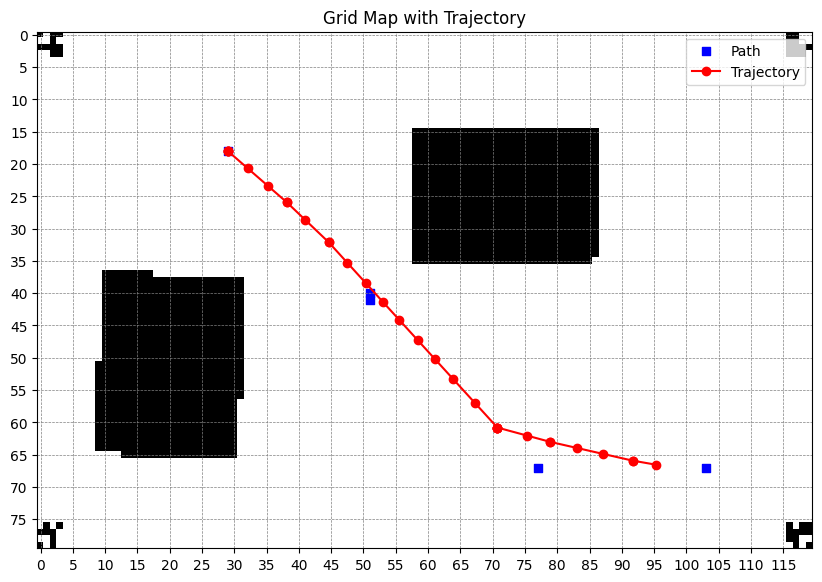

-------------------------------------------------------------------------------------------------
MAIN: goal reached


In [ ]:
# leds off during the navigation
leds_off()

# initialize objects
globalPlanning = GlobalPlanning()
localPlanning = LocalPlanning()
filter = Kalman()
thymio = ThymioControl()
plotter = Plotter()

# initialize variables for saving the trajectory and the Kalman filter positions
row_trajectory = []
col_trajectory = []
kalman_positions = []

# timeout for the loop
timeout = 0.1
# delta time between iterations, considering all the computation time
dt = 0
# old time to compute the delta time
old_time = time.time_ns()

# create a vision object
image_path = "images/original_image.jpeg"
vision = Vision(fps=3,target_height=80, default_image_path=image_path)

# iteration counter
iter = 1

# variables for position and angle
position = None
angle = None

# flag to check if the goal is reached
goal = False

# -------------------------------------------------------------------------------------------------
# initialization from vision
vision.update_image(live=False)
print("MAIN: initializing vision")
print("MAIN: Getting map and Thymio position from camera")
# getting the initial position and angle from the camera
pos_vision = vision.getStart()
angle_vision = vision.getAngle()
if pos_vision is None:
    print("MAIN: ERROR: camera obstructed in the first iteration")
    exit()
# getting the map from the camera
map = vision.getMatrix()
# setting the scale of the map
thymio.set_scale(vision.getScale())
print("MAIN: scale: ", vision.getScale())
# setting the initial position and angle of the Thymio
thymio.set_pose(pos_vision, angle_vision)
# initializing the Kalman filter
filter.initialize_position(thymio.cells_to_mm(pos_vision[0]), thymio.cells_to_mm(pos_vision[1]), angle_vision)
print("MAIN: initialized kalman: ", filter.get_state())
# computing the path from the initial position to the goal
print("MAIN: computing path")
goal_pos = vision.getGoal()
print("MAIN: goal: ", goal_pos)
print("MAIN: start: ", pos_vision)
globalPlanning.set_magnification(vision.getScale(), thymio.get_wheel_distance())
path = globalPlanning.dijkstra(map.copy(), pos_vision, goal_pos)
if path == None:
    print("MAIN: ERROR: no path found")
    exit()
print("MAIN: path: ", path)
# setting the map and the path to the plotter
plotter.set_map(map, pos_vision, goal_pos)
plotter.plot_map()
# setting the path to the Thymio object
thymio.set_path(path)
print("MAIN: reduced path", thymio.get_path_cells())
plotter.plot_path(thymio.get_path_cells())
# -------------------------------------------------------------------------------------------------

# update time
old_time = time.time_ns()

while not goal:
    print("MAIN: iter: ", iter)
    print("MAIN: position: ", position)
    print("MAIN: angle: ", angle)
    print("MAIN: dt: ", dt)

    # vision.update_image(live=False)
    # pos_vision = vision.getStart()
    pos_vision = [thymio.mm_to_cells(thymio.get_position()[0]), thymio.mm_to_cells(thymio.get_position()[1])]
    # angle_vision = vision.getAngle()
    angle_vision = thymio.get_angle()

    # check if camera is obstructed
    if pos_vision is not None:
        # position here is the measurement from the camera
        print("MAIN: Camera not obstructed, getting position from camera")
        
        # check if the robot has been kidnapped
        # if the position from the camera is too far from the Kalman filter prediction
        if thymio.amIKidnapped(pos_vision, angle_vision):
            print("MAIN: kidnapping detected")

            # tmdclient function to stop the motors
            motor_stop()

            # update the map with new robot position
            time.sleep(2)
            
            # vision.update_image(live=False)
            # pos_vision = vision.getStart()
            # angle_vision = vision.getAngle()
            # setting the scale of the map
            # thymio.set_scale(vision.getScale())
            # filter.initialize_position(thymio.cells_to_mm(pos_vision[0]), thymio.cells_to_mm(pos_vision[1]), angle_vision)

            # new path planning
            map = vision.getMatrix()
            globalPlanning.set_magnification(vision.getScale(), thymio.get_wheel_distance())
            path = globalPlanning.dijkstra(map.copy(), pos_vision, goal_pos)
            if path == None:
                print("MAIN: ERROR: no path found")
                exit()
            thymio.set_path(path)
            plotter.plot_path(thymio.get_path_cells())

        """
        if vision.getGoal() != goal_pos:
            print("MAIN: goal changed")
            goal_pos = vision.getGoal()
            path = globalPlanning.dijkstra(map, pos_vision, goal_pos)
            thymio.set_path(path)
            plotter.plot_path(thymio.get_path_cells())
        """

        # camera measuerement that will then be used for the Kalman filter
        measurement = np.array([thymio.cells_to_mm(pos_vision[0]), thymio.cells_to_mm(pos_vision[1]), angle])
        # filter.kalman_update(measurement)
        # print("MAIN: kalman update: ", filter.get_state())
    
    else:
        print("MAIN: camera obstructed")

    # get the state from the Kalman filter after the update
    x, y, angle = filter.get_state()
    position = [x, y]
    print("MAIN: kalman position used: ", position)
    print("MAIN: kalman angle used: ", angle)
    row_trajectory.append(float(thymio.mm_to_cells(x)))
    col_trajectory.append(float(thymio.mm_to_cells(y)))

    # update the pose of the Thymio in the ThymioControl object
    # the update will come either from:
    #     prediction the iteration before + update from the camera this iteration
    #     prediction the iteration before (no update from the camera)
    thymio.update_pose(position, angle)

    # check if the robot is detecting an obstacle
    # tmclient function to get the proximity sensors
    # prox = sensor_data()
    prox = [0, 0, 0, 0, 0]
    print("MAIN: proximity sensors: ", prox)
    if (localPlanning.is_obstacle_avoidance(prox)):
        # move with local planning until the robot is not back on the path
        wl, wr = localPlanning.obstacle_avoidance(prox)
        v, w = thymio.inverseDifferentialDrive(wl, wr)
        # do not move the first iteration, need to set the dt
        if dt == 0:
            wl, wr = 0, 0
    else:
        # move with global planning
        v, w, wl, wr, goal = thymio.move(position, angle, dt)

    print("MAIN: speed: ", thymio.convert_speed_cells(v), w)
    print("MAIN: motor commands: ", wl, wr)
    
    # update the Kalman filter
    filter.kalman_prediction(wl, wr, dt)
    print("MAIN: kalman prediction: ", filter.get_state())
    px, py, pa = filter.get_state()
    thymio.set_pred(px, py, pa)
    # also update the pose of the Thymio with the prediction because there is no camera update
    thymio.update_pose([px, py], pa)

    print("MAIN: trajectory: ", row_trajectory, col_trajectory)
    plotter.plot_trajectory(row_trajectory, col_trajectory)

    # tmdclient function to move the motors
    # motor_go(int(wl), int(wr))
    
    # sleep for a while
    iter += 1
    time.sleep(timeout)
    dt = (time.time_ns() - old_time) / 1e9
    old_time = time.time_ns()
    print("-------------------------------------------------------------------------------------------------")

print("MAIN: goal reached")
motor_stop()
leds_go_crazy()
leds_off()

In [7]:
motor_stop()